
#Partie 1 : Extraction de données sur base des csv

Test sur le projet insérez les fichiers suivant avant d'exécuter le code :




---


*   links.csv
*   movies.csv



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
df_movies = pd.read_csv("/content/drive/MyDrive/UCL/Cours/M1/Q1/P2/Web Mining/Projet/Data/movies.csv") # contient data de movie.csv

file_links = open("/content/drive/MyDrive/UCL/Cours/M1/Q1/P2/Web Mining/Projet/Data/links.csv","r")    # ouverture de file en lecture 
content_f_links = file_links.read().splitlines()      # save contenu dans une variable
file_links.close()     # fermeture file
#print(content_f_links)
# code pour voir si le code tmdb est présent
#for i in range(610):
  #a = content_f_links[i].split(",")
  #print(a[0],a[2], len(a[2]))
df_movies 

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9120,162672,Mohenjo Daro (2016),Adventure|Drama|Romance
9121,163056,Shin Godzilla (2016),Action|Adventure|Fantasy|Sci-Fi
9122,163949,The Beatles: Eight Days a Week - The Touring Y...,Documentary
9123,164977,The Gay Desperado (1936),Comedy


In [3]:
# fct qui vérifie que l'année est disponible dans le fichier csv

def find_year(phrase:str):
  i = -1
  result = "?"
  for j in range(len(phrase)):
    if phrase[i] == ")":
      i_start = i - 4
      result = phrase[i_start:i]
      return result
    i-=1
    j+=1
  return result

In [4]:
# list_overview_1[movie_id, movie_year, [movie_genres], imdb_code, tmdb_code]
# c'est les info que l'on va garder
# on va extraire le titre directment sur le site par après. Car l'agencement du site n'est pas bien fait dans le fichier csv

list_overview_1 = []    # va contenir les données essentiel dont les codes tmdb des films
list_tempo_1 = []       # pour enregistrer le résult de chaque movie
list_tmdb_missing = []

for i in range(1, len(content_f_links)):
  list_tempo_links = content_f_links[i].split(",")  #contient une ligne d'info complet
  movie_id = list_tempo_links[0]
  movie_year = df_movies["title"][i-1]              # l'année se trouvre à movie_year[-5:-1]
  list_genre = df_movies["genres"][i-1].split("|")
  imdb_code = list_tempo_links[1]
  tmdb_code = list_tempo_links[2]

  # ici je teste que la date est bien disponible
  movie_year = find_year(movie_year)
  
  # ici je teste pour voir s'il y a un genre identifié dans le fichier csv
  if list_genre[0] == "(no genres listed)":
    list_genre[0] = "?"

  # on va rajouter chaque varibale dans la list_tempo_1 avant d'incrémenter i
  if ((len(tmdb_code) != 0) and (len(imdb_code) != 0)):   # certains film ne possèdent pas de code imdb
    list_tempo_1.append(movie_id),list_tempo_1.append(movie_year), list_tempo_1.append(list_genre), list_tempo_1.append(imdb_code), list_tempo_1.append(tmdb_code)
    list_overview_1.append(list_tempo_1)  # ajout de la list_tempo dans list_overview_1
  else:
    list_tmdb_missing.append(movie_id)
  list_tempo_1 = []   # réinitialiser à vide
  i+=1
print(f"les movie_id n'ayant pas de tmdb_code = > {list_tmdb_missing}")
print(f"totalt = {len(list_tmdb_missing)}")

# pour tester 
#print(list_overview_1)
#for i in range(610):
  #print(list_overview_1[i])

les movie_id n'ayant pas de tmdb_code = > ['720', '721', '769', '1133', '2851', '4051', '26587', '72781', '73759', '79299', '94466', '108548', '108583']
totalt = 13


In [5]:
# on fait deux listes content les movie_id ayant des données manquantes
list_year_missing = [] 
list_genres_missing = []
count_nb_movies = 0   # nbr de film total utile pour plus tard

for data in list_overview_1:
  if data[1] == "?":      # s'il manque l'année
    list_year_missing.append(data[0])
  if data[2][0] == "?":   # s'il manque le genre 
    list_genres_missing.append(data[0])
  count_nb_movies +=1
print(f"Année unknown => {list_year_missing}, total : {len(list_year_missing)}")
print(f"Genre unknown => {list_genres_missing}, total : {len(list_genres_missing)}") 
print(f"Total movies => {count_nb_movies}")

Année unknown => ['143410', '151307', '162376', '164979'], total : 4
Genre unknown => ['83829', '117192', '122888', '126106', '128616', '128620', '129250', '132549', '132952', '134025', '136592', '140753', '140763', '141866', '143410', '149532', '151307', '160590'], total : 18
Total movies => 9112


Il y a 4 films qui ne contiennent pas l'année de sortie.
Il y a 18 films qui ne contiennent pas le genre.
Comme nous allons quand même devoir retirer les informations utiles sur leur page web nous n'en tiendrons pas comptes ici.

Il y a 13 films qui n'ont pas de code tmdb, nous l'utiliserons pas c'est film car dans notre cas nous allons utiliser les données disponnibles sur tmdb. 
Nous utilisons ce site car il présent un résumé de film qui est un peu plus précis que celui présent sur imdb. Cela nous a semblé important d'avoir des phrases plus précises pour la partie sur le text mining. 


Il y a un totale de 9125 films.

# Partie 2 : Scrapting

** Step 1 **

** Création de fonction pour le Scraping **

Sur base sur code_tmdb on va extraire les données suivantes:

movie_title, movie_summary, movie_note, movie_year, movie_genre, movie_date, movie_runtime (en min), movie_genre, movie_director_name, movie_actor_name, movie_buget, movie_revenue.

In [6]:
# package 
import requests
import pandas as pd
from bs4 import BeautifulSoup

In [7]:
# fonction pour avoir accès aux différentes classes de la page html
# tranformer le tout en utilisant BeautifulSoup

def check_page(url:str): 
    # In this case , we are going to give request.get function headers to avoid the Status code Error 403

    get_headers = {'User-Agent': "Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.131 Safari/537.36"}
    # we are going to raise exception here if status code gives any value other than 200.
    try:
      response_page = requests.get(url, headers = get_headers )
      response_page.ok
    except:
      return False
    return True

def get_page_content(url:str):
    # In this case , we are going to give request.get function headers to avoid the Status code Error 403

    get_headers = {'User-Agent': "Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.131 Safari/537.36"}
    response_page = requests.get(url, headers = get_headers )
    # we are going to raise exception here if status code gives any value other than 200.
    page_content = response_page.text
    doc_page = BeautifulSoup(page_content, "html.parser") 
    return doc_page
def get_title(doc_page):
  try:
    doc_page.h2.a.string
  except:
    x = "?"
    return x
  return str(doc_page.h2.a.string)
def get_summary(doc_page):
  try:
    doc_page.p.string
  except:
    x = "?"
    return x
  return str(doc_page.p.string)
def get_note(doc_page):
  tag = doc_page.find('div', class_ = 'user_score_chart')
  try:
    note = float(tag.attrs['data-percent']) /10
  except:
    return "0"
  return note
def get_year(doc_page):
  try:
    year = doc_page.h2.span.string[1:-1] # on élimine les parenthèses
  except:
    x = 0
    return 0
  return int(year)
def get_date(doc_page):
  tag = doc_page.find("span", class_ = "release")
  try:
    date = tag.text.split()[0]
  except:
    x = "?"
    return x
  return date
def get_runtime(doc_page):
  tag = doc_page.find("span", class_ = "runtime")
  try :
    runtime = tag.text.split()
  except:
    x = "0m"
    return x
  runtime = convert_runtime(runtime)
  return runtime
def get_genre(doc_page):
  tag_genre = doc_page.find('span', {"class": "genres"})
  try:
    tag_genre_list = tag_genre.find_all('a')
  except:
    x = []
    return x

  list_genre =[]
  for tag in tag_genre_list:
    list_genre.append(tag.text)
  return list_genre
def get_director(doc_page):
  tag = doc_page.find('li', class_ = 'profile')
  try:
    director = tag.p.string
  except:
    x = "?"
    return x
  return str(director)
def get_actor(doc_page):
  try:
    tag = doc_page.find_all('li', {'class': 'card'})
  except:
    return []
  list_actor = []
  for t in tag:
    list_actor.append(t.p.text)
  return list_actor
def get_budget_revenue(doc_page):
  tag_1 = doc_page.find("section", class_ = "facts left_column")
  try:
    tag_2 = tag_1.find_all("p")
  except:
    x = ("","")
    return x
  list_result = []
  for i in tag_2:
    list_result.append(i.text)
  budget, revenue = list_result[-2][7:-3], list_result[-1][8:-3]
  return budget, revenue
def get_all_1(tmdb_code):
  url_tmdb = "https://www.themoviedb.org/movie/" + tmdb_code
  soup_tmdb = get_page_content(url_tmdb)

  title  = get_title(soup_tmdb)
  summary = get_summary(soup_tmdb)
  note = get_note(soup_tmdb)
  year = get_year(soup_tmdb)
  date = get_date(soup_tmdb)
  runtime = get_runtime(soup_tmdb)
  genre = get_genre(soup_tmdb)
  director_name = get_director(soup_tmdb)
  actor_name = get_actor(soup_tmdb)
  budget_revenu = get_budget_revenue(soup_tmdb)

  return title, summary, note, year, date, runtime, genre, director_name, actor_name, budget_revenu
def convert_runtime(list_runtime):    # fct pour convertir le runtime en min
  #print(list_runtime)
  result_min = 0    
  if len(list_runtime) > 1:
    heure = list_runtime[0]
    min = list_runtime[1]
    exposant = 0
    result_min += (int(heure[0]) * 60) # conversion de l'heure
    for i in range(2, (len(min) + 1) ): 
      result_min += (int(min[-i]) * (10 **exposant)) # on commence par l'élément après le m
      exposant += 1
    return result_min
  
  min = list_runtime[0]
  exposant = 0
  end = (len(min) + 1)
  for i in range(2, end): 
    x = int(min[-i]) * (10 **exposant)
    result_min += x # on commence par l'élément après le m
    exposant += 1
  return result_min

In [8]:
# test des fct de scraping pour un film 
url = "https://www.themoviedb.org/movie/869"

soup = get_page_content(url)

print(get_title(soup))
print(type(get_title(soup)))
print(get_summary(soup))
print(type(get_summary(soup)))
print(get_note(soup))
print(type(get_note(soup)))
print(get_year(soup))
print(type(get_year(soup)))
print(get_date(soup))
print(type(get_date(soup)))
print(get_runtime(soup))
print(type(get_runtime(soup)))
print(get_genre(soup))
print(type(get_genre(soup)))
print(get_director(soup))
print(type(get_director(soup)))
print(get_actor(soup))
print(type(get_actor(soup)))
print(get_budget_revenue(soup))
print(type(get_budget_revenue(soup)))


Planet of the Apes
<class 'str'>
After a spectacular crash-landing on an uncharted planet, brash astronaut Leo Davidson finds himself trapped in a savage world where talking apes dominate the human race. Desperate to find a way home, Leo must evade the invincible gorilla army led by Ruthless General Thade.
<class 'str'>
5.7
<class 'float'>
2001
<class 'int'>
07/27/2001
<class 'str'>
119
<class 'int'>
['Thriller', 'Science Fiction', 'Action', 'Adventure']
<class 'list'>
Tim Burton
<class 'str'>
['Mark Wahlberg', 'Tim Roth', 'Helena Bonham Carter', 'Michael Clarke Duncan', 'Kris Kristofferson', 'Estella Warren', 'Paul Giamatti', 'Cary-Hiroyuki Tagawa', 'Glenn Shadix']
<class 'list'>
('$100,000,000', '$362,211,740')
<class 'tuple'>


In [9]:
# module pour écrire dans un fichier excel
!pip install xlsxwriter 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 KB 4.7 MB/s eta 0:00:00


Création d'un code pour automatiser la collecte de données de tout les page web de film. A partir du code tmdb


In [10]:
def extract_data_in_csv():
  # title, summary, note, year, date, runtime, genre, director_name, actor_name, budget_revenu
  list_title, list_summary, list_note, list_year, list_date, list_runtime, list_genre, list_director, list_actor, list_budget, list_revenu = [], [], [], [], [], [], [], [], [], [] ,[]
  list_movie_id = []
  #for i in range(len(list_overview_1)):   # on va parcourir les films qui ont un code imdb
  for i in range(10):   # test sur uniquement les 10 premiers films 
    data = list_overview_1[i]
    tmdb_code = data[-1]
    print(data[0])      # pour vérifier le code en cours d'éxécution si erreur
    url_tmdb = "https://www.themoviedb.org/movie/" + tmdb_code
    if not check_page(url_tmdb): # si le site n'est pas accéssible 
      print("x")
      continue                    # on passe au site tmdb_code suivant
    result = get_all_1(tmdb_code)

    # on va rajouter les éléments de résult dans les listes correspondantes 

    list_title.append(result[0]), list_summary.append(result[1]), list_note.append(result[2])
    list_year.append(result[3]), list_date.append(result[4]), list_runtime.append(result[5])
    list_genre.append(result[6]), list_director.append(result[7]), list_actor.append(result[8])
    list_budget.append(result[9][0]), list_revenu.append(result[9][1])
    list_movie_id.append(data[0])   # on rajoute le movie_id

  dict_all_data = {
      "Movie_id" : list_movie_id,
      "Title" : list_title,
      "Summary" : list_summary,
      "Rate" : list_note,
      "Year" : list_year,
      "Realease Date" : list_date,
      "Duration (min)" : list_runtime,
      "Genre" : list_genre,
      "Director" : list_director,
      "Actor" : list_actor,
      "Budget" : list_budget,
      "Revenu" : list_revenu
  }
  return pd.DataFrame(dict_all_data)
#df_movies = extract_data_in_csv()
#df_movies.to_excel("Output_Scrapting_TMDB.xlsx")
#df_movies

Maitenant, sur base du fichier "Output_Scrapting_TMDB.xlsx" on commencer l'analyse

# Partie 3 analyse générale

In [11]:
import pandas as pd

df = pd.read_excel("/content/drive/MyDrive/UCL/Cours/M1/Q1/P2/Web Mining/Projet/Data/Output_Scrapting_TMDB.xlsx") # nos données obtenue précédemment
df.drop("Unnamed: 0", inplace = True, axis = 1) # pour retirer la colonne inutile crée par défaut dans le fichier xlsx
df

,Movie_id,Title,Summary,Rate,Year,Realease Date,Duration (min),Genre,Director,Actor,Budget,Revenu
0,1,Toy Story,"Led by Woody, Andy's toys live happily in his ...",8.0,1995,11/22/1995,81,"['Animation', 'Adventure', 'Family', 'Comedy']",John Lasseter,"['Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim...","$30,000,000","$373,554,033"
1,2,Jumanji,When siblings Judy and Peter discover an encha...,7.2,1995,03/28/1996,104,"['Adventure', 'Fantasy', 'Family']",Joe Johnston,"['Robin Williams', 'Kirsten Dunst', 'Bradley P...","$65,000,000","$262,821,940"
2,3,Grumpier Old Men,A family wedding reignites the ancient feud be...,6.4,1995,12/22/1995,101,"['Romance', 'Comedy']",Mark Steven Johnson,"['Walter Matthau', 'Jack Lemmon', 'Ann-Margret...","$25,000,000","$71,500,000"
3,4,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",6.3,1995,12/22/1995,127,"['Comedy', 'Drama', 'Romance']",Terry McMillan,"['Whitney Houston', 'Angela Bassett', 'Loretta...","$16,000,000","$81,452,156"
4,5,Father of the Bride Part II,Just when George Banks has recovered from his ...,6.2,1995,12/08/1995,106,"['Comedy', 'Family']",Charles Shyer,"['Steve Martin', 'Diane Keaton', 'Martin Short...",NaN,"$76,594,107"
...,...,...,...,...,...,...,...,...,...,...,...,...
9107,162672,Mohenjo Daro,"During the Indus valley civilization, an Indig...",6.4,2016,08/12/2016,155,"['Adventure', 'Drama', 'History', 'Romance']",Ashutosh Gowariker,"['Hrithik Roshan', 'Pooja Hegde', 'Kabir Bedi'...","$17,000,000","$16,000,000"
9108,163056,Shin Godzilla,"When a massive, gilled monster emerges from th...",7.1,2016,08/12/2016,2,"['Action', 'Science Fiction', 'Horror']",Hideaki Anno,"['Hiroki Hasegawa', 'Yutaka Takenouchi', 'Sato...","$15,000,000","$77,947,607"
9109,163949,The Beatles: Eight Days a Week - The Touring Y...,The Beatles stormed through Europe's music sce...,7.6,2016,09/16/2016,106,['Documentary'],Ron Howard,"['Paul McCartney', 'Ringo Starr', 'John Lennon...",NaN,"$12,283,800"
9110,164977,The Gay Desperado,Opera singer Chivo is currently playing a sing...,2.0,1936,01/01/1936,86,"['Music', 'Comedy']",Rouben Mamoulian,"['Nino Martini', 'Ida Lupino', 'Leo Carrillo',...",NaN,NaN


Fonction pour ne garder que les films qui ont des données complet

In [12]:
# on va renvoyer à chaque fois True pour les movie_id qui ne sont pas complets
# car ceux qui manquent sont moins nombreux que ceux qui sont complets
def title_missing(i):
  if df.Title[i] == "?":
    return True
  return False
def summary_missing(i):
  if df.Summary[i] == "?":
    return True
  return False
def rate_missing(i):
  if df.Rate[i] == 0:
    return True
  return False
def year_missing(i):
  if df.Year[i] == 0:
    return True
  return False
def date_missing(i):
  if df["Realease Date"][i] == "?":
    return True
  return False
def duration_missing(i):
  if df["Duration (min)"][i] == "0m":
    return True
  return False
def genre_missing(i):
  if df.Genre[i] == "[]":
    return True
  return False
def director_missing(i):
  if df.Director[i] == "?":
    return True
  return False
def actor_missing(i):
  if df.Actor[i] == "[]":
    return True
  return False
def profit_missing(i):   
  if (type(df.Budget[i]) == float or type(df.Revenu[i]) == float):    # si l'un des deux est manquant alors sa valeur c'est NaN qui a un type float
    return True   # et donc on ne peut pas avoir le profit car une ou plusieur 
  return False

# cette fonction va verifier que le tout les informations sont présente pour chaque movie_id
# on va renvoye une liste avec les movie_id qui sont complets
def check_missing():
  result = []
  for i in range(len(df)):
    if not title_missing(i):
      if not summary_missing(i):
        if not rate_missing(i):
          if not year_missing(i):
            if not date_missing(i):
              if not duration_missing(i):
                if not genre_missing(i):
                  if not director_missing(i):
                    if not actor_missing(i):
                      if not profit_missing(i):
                        result.append(df.Movie_id[i])
  return result
x = check_missing()   # contient la liste des movie_id qui sont complets 
print(x)
print(len(x))     # contient le nbr de movie qui sont complet 

[1, 2, 3, 4, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 29, 31, 32, 34, 36, 39, 42, 44, 45, 46, 47, 48, 50, 52, 61, 62, 63, 65, 66, 69, 70, 71, 76, 79, 81, 86, 89, 92, 93, 95, 97, 101, 104, 105, 107, 110, 111, 112, 113, 118, 119, 122, 125, 132, 141, 145, 147, 148, 150, 151, 153, 155, 156, 157, 158, 159, 160, 161, 163, 164, 165, 168, 169, 170, 172, 173, 175, 176, 180, 181, 185, 187, 188, 191, 193, 194, 196, 198, 200, 201, 204, 207, 208, 213, 215, 216, 218, 223, 224, 225, 227, 231, 233, 235, 239, 240, 244, 246, 247, 248, 250, 251, 252, 253, 254, 256, 259, 260, 261, 262, 265, 266, 270, 271, 273, 280, 282, 288, 292, 293, 294, 296, 300, 303, 304, 305, 313, 315, 316, 317, 318, 322, 327, 328, 329, 330, 332, 337, 338, 339, 342, 344, 345, 347, 349, 350, 353, 355, 356, 357, 360, 361, 364, 365, 366, 367, 368, 370, 371, 372, 373, 374, 376, 377, 379, 380, 382, 383, 387, 391, 393, 405, 407, 410, 412, 414, 415, 420, 422, 423, 426, 428, 431, 432, 434, 435, 436, 439, 4

In [13]:
df_2 = df[df.Movie_id.isin(x)]    # x contient la list des movies qui sont complets
df_2


,Movie_id,Title,Summary,Rate,Year,Realease Date,Duration (min),Genre,Director,Actor,Budget,Revenu
0,1,Toy Story,"Led by Woody, Andy's toys live happily in his ...",8.0,1995,11/22/1995,81,"['Animation', 'Adventure', 'Family', 'Comedy']",John Lasseter,"['Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim...","$30,000,000","$373,554,033"
1,2,Jumanji,When siblings Judy and Peter discover an encha...,7.2,1995,03/28/1996,104,"['Adventure', 'Fantasy', 'Family']",Joe Johnston,"['Robin Williams', 'Kirsten Dunst', 'Bradley P...","$65,000,000","$262,821,940"
2,3,Grumpier Old Men,A family wedding reignites the ancient feud be...,6.4,1995,12/22/1995,101,"['Romance', 'Comedy']",Mark Steven Johnson,"['Walter Matthau', 'Jack Lemmon', 'Ann-Margret...","$25,000,000","$71,500,000"
3,4,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",6.3,1995,12/22/1995,127,"['Comedy', 'Drama', 'Romance']",Terry McMillan,"['Whitney Houston', 'Angela Bassett', 'Loretta...","$16,000,000","$81,452,156"
5,6,Heat,Obsessive master thief Neil McCauley leads a t...,7.9,1995,12/15/1995,170,"['Action', 'Crime', 'Drama', 'Thriller']",Michael Mann,"['Al Pacino', 'Robert De Niro', 'Val Kilmer', ...","$60,000,000","$187,436,818"
...,...,...,...,...,...,...,...,...,...,...,...,...
9096,160954,Nerve,Industrious high school senior Vee Delmonico h...,7.1,2016,07/27/2016,96,"['Mystery', 'Adventure', 'Crime']",Henry Joost,"['Emma Roberts', 'Dave Franco', 'Emily Meade',...","$19,000,000","$85,241,496"
9100,161582,Hell or High Water,A divorced dad and his ex-con brother resort t...,7.3,2016,09/23/2016,102,"['Crime', 'Drama', 'Thriller', 'Western']",David Mackenzie,"['Jeff Bridges', 'Chris Pine', 'Ben Foster', '...","$12,000,000","$37,589,296"
9106,162542,Rustom,A naval officer is devastated to learn about h...,7.0,2016,08/12/2016,148,"['Thriller', 'Drama', 'Crime']",Vipul K Rawal,"['Akshay Kumar', ""Ileana D'Cruz"", 'Esha Gupta'...","$6,114,349","$26,309,214"
9107,162672,Mohenjo Daro,"During the Indus valley civilization, an Indig...",6.4,2016,08/12/2016,155,"['Adventure', 'Drama', 'History', 'Romance']",Ashutosh Gowariker,"['Hrithik Roshan', 'Pooja Hegde', 'Kabir Bedi'...","$17,000,000","$16,000,000"


In [14]:
a = df_2.Genre.iloc[:5]
a

0    ['Animation', 'Adventure', 'Family', 'Comedy']
1                ['Adventure', 'Fantasy', 'Family']
2                             ['Romance', 'Comedy']
3                    ['Comedy', 'Drama', 'Romance']
5          ['Action', 'Crime', 'Drama', 'Thriller']
Name: Genre, dtype: object

In [15]:
# icic on ne garde que les data avec une note de min 7
rate_7_min = df_2.Rate >= 7
#print(rate_7_min)
df_rate_7 = df_2[rate_7_min]  
#df_rate_7.to_excel("df_rate_7.xlsx")
df_rate_7   # c'est avec cette data que l'on va faire l'ensemble de nos annalyses

,Movie_id,Title,Summary,Rate,Year,Realease Date,Duration (min),Genre,Director,Actor,Budget,Revenu
0,1,Toy Story,"Led by Woody, Andy's toys live happily in his ...",8.0,1995,11/22/1995,81,"['Animation', 'Adventure', 'Family', 'Comedy']",John Lasseter,"['Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim...","$30,000,000","$373,554,033"
1,2,Jumanji,When siblings Judy and Peter discover an encha...,7.2,1995,03/28/1996,104,"['Adventure', 'Fantasy', 'Family']",Joe Johnston,"['Robin Williams', 'Kirsten Dunst', 'Bradley P...","$65,000,000","$262,821,940"
5,6,Heat,Obsessive master thief Neil McCauley leads a t...,7.9,1995,12/15/1995,170,"['Action', 'Crime', 'Drama', 'Thriller']",Michael Mann,"['Al Pacino', 'Robert De Niro', 'Val Kilmer', ...","$60,000,000","$187,436,818"
12,13,Balto,An outcast half-wolf risks his life to prevent...,7.3,1995,12/22/1995,78,"['Family', 'Animation', 'Adventure']",Elana Lesser,"['Kevin Bacon', 'Bob Hoskins', 'Bridget Fonda'...","$31,000,000","$11,348,324"
15,16,Casino,"In early-1970s Las Vegas, Sam ""Ace"" Rothstein ...",8.0,1995,11/22/1995,179,"['Crime', 'Drama']",Martin Scorsese,"['Robert De Niro', 'Sharon Stone', 'Joe Pesci'...","$52,000,000","$116,112,375"
...,...,...,...,...,...,...,...,...,...,...,...,...
9084,159858,The Conjuring 2,Lorraine and Ed Warren travel to north London ...,7.3,2016,06/08/2016,134,"['Horror', 'Thriller']",James Wan,"['Patrick Wilson', 'Vera Farmiga', 'Madison Wo...","$40,000,000","$320,392,818"
9096,160954,Nerve,Industrious high school senior Vee Delmonico h...,7.1,2016,07/27/2016,96,"['Mystery', 'Adventure', 'Crime']",Henry Joost,"['Emma Roberts', 'Dave Franco', 'Emily Meade',...","$19,000,000","$85,241,496"
9100,161582,Hell or High Water,A divorced dad and his ex-con brother resort t...,7.3,2016,09/23/2016,102,"['Crime', 'Drama', 'Thriller', 'Western']",David Mackenzie,"['Jeff Bridges', 'Chris Pine', 'Ben Foster', '...","$12,000,000","$37,589,296"
9106,162542,Rustom,A naval officer is devastated to learn about h...,7.0,2016,08/12/2016,148,"['Thriller', 'Drama', 'Crime']",Vipul K Rawal,"['Akshay Kumar', ""Ileana D'Cruz"", 'Esha Gupta'...","$6,114,349","$26,309,214"


Sur un total de 9112 films nous sommes passé à 4719 films complètes c'est à dire qui contiennent la totalité des inforamtions que nous voulions.

movie_title, movie_summary, movie_note, movie_year, movie_genre, movie_date, movie_runtime (en min), movie_genre, movie_director_name, movie_actor_name, movie_buget, movie_revenue.

Enfin nous avons filtrer ces données pour finir avec les films ayant une note de minimum 7. Cela nous fait 1527 films à analysé pour ce projet soit 16,76% de nos films de départ. 
Nous avons fait ce filtrage pour s'assurer de la qualité de notre analyse. Pour ce qui est du filtre par rapport à la note de 7 nous avons considérer qu'un bon film a une note de min 7.

Commençons par analyser ces films dans le temps

[1995 1996 1976 1994 1977 1992 1993 1982 1990 1991 1989 1937 1940 1969
 1970 1964 1972 1952 1951 1961 1958 1954 1934 1959 1960 1963 1942 1941
 1953 1944 1939 1950 1968 1946 1945 1957 1955 1938 1935 1936 1956 1971
 1981 1965 1988 1979 1967 1987 1986 1975 1980 1985 1966 1962 1983 1974
 1984 1973 1948 1978 1997 1998 1927 1930 1932 1947 1933 1999 1931 1926
 1921 2000 1949 1925 2001 2002 2003 1920 1916 2004 1924 1923 2005 2006
 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016]
nombre d'année différentes :  94
min : 1916 max : 2016


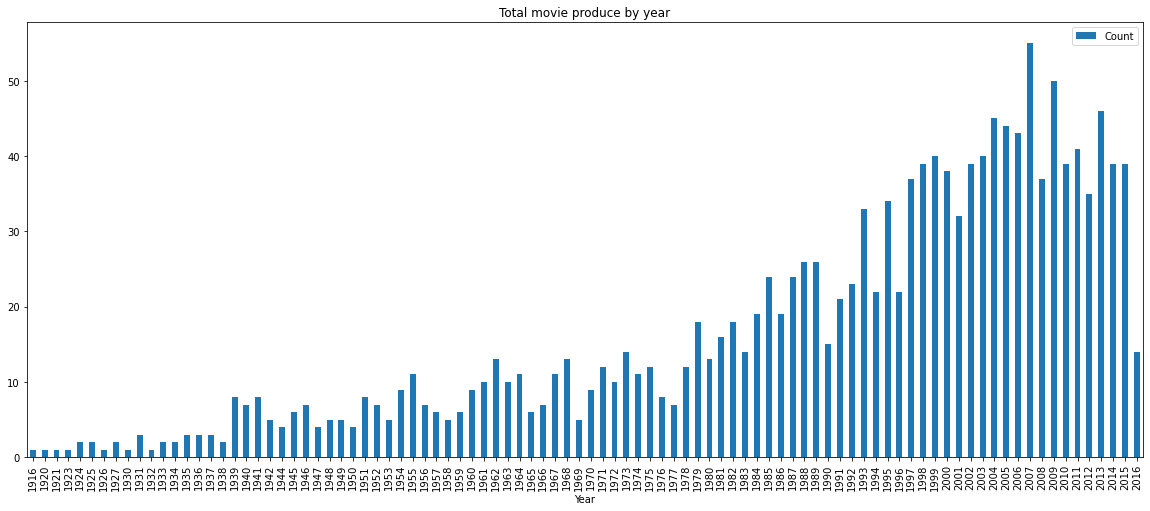

In [16]:
# ici on va compter le nbr de film par années 

x = df_rate_7.Year.unique() # les
print(x)
print("nombre d'année différentes : ", len(x))
print("min :",min(x),"max :", max(x))
dic_year = {}
for i in x:
  dic_year[str(i)] = 0
#print(dic_year) # initialisation
for year in df_rate_7.Year:
  count = dic_year[str(year)]
  dic_year[str(year)] = count + 1
#print(dic_year) # film comptabilisé
df_year_count = pd.DataFrame(dic_year, index=[0]) # obliger de mettre index=[0] sinon ValueError: If using all scalar values, you must pass an index
#df_year_count

list_year, list_count = [], []
dic_year_2 = {}
for year, count in dic_year.items():
  list_year.append(year)
  list_count.append(count)
dic_year_2["Year"] = list_year
dic_year_2["Count"] = list_count
#print(dic_year_2)
df_year_count = pd.DataFrame(dic_year_2)
x = df_year_count.sort_values(by=["Year"], ascending=True)   # data classé de manière croissant selon l'année
x.plot.bar(x="Year", y="Count",  title="Total movie produce by year",figsize=(20,8))
# df_year_count.sort_values(by=["Year"], ascending=True).to_excel("Year_count.xlsx") # pour télécharger les data 


On va regarder le genre de ces films 

movie_title, movie_summary, movie_note, movie_year, movie_genre, movie_date, movie_runtime (en min), movie_genre, movie_director_name, movie_actor_name, movie_buget, movie_revenue.

In [17]:
from pandas.core.groupby.grouper import DataFrame
# on va compter le genre total
def get_word(word):
  result = ""
  for l in word:
    if (l != "'" and l != ","):
      result += l
  if result == "TV" or result == "Movie":
    result = ""
  return result
#x = "'Animation',"
#print(get_word(x))

list_genre = []
for data_1 in df_rate_7.Genre :
  data_2 = data_1[1:-1].split()
  for i in data_2:
    word = get_word(i)
    if word == "Science" or word == "Fiction":
      word = "Science Fiction"
    if word not in list_genre and word != "":
      list_genre.append(word)
print(list_genre)
print(len(list_genre))

# initialisation dico 1 
dic_genre_1 = {}
for genre in list_genre:
  dic_genre_1[genre] = 0
for data_1 in df_rate_7.Genre :
  data_2 = data_1[1:-1].split()
  for i in data_2:
    word = get_word(i)
    if word == "Science" or word == "Fiction":
      word = "Science Fiction"
    if word != "":
      count = dic_genre_1[word]
      dic_genre_1[word] = count + 1
print(dic_genre_1)

# initialisation dico 2 
dic_genre_2 = {}
key = ["Genre", "Count"]
list_key, list_count = [], []
for k, v in dic_genre_1.items():
  list_key.append(k)
  list_count.append(v)
dic_genre_2["Genre"] = list_key
dic_genre_2["Count"] = list_count
print(dic_genre_2)
df_genre_count = pd.DataFrame(dic_genre_2)
df_genre_count.sort_values(by=["Count"], ascending=False)   # classé de manière décroissant
#df_genre_count.sort_values(by=["Count"], ascending=True).to_excel("df_genre_count.xlsx")   # pour télécharger les data

['Animation', 'Adventure', 'Family', 'Comedy', 'Fantasy', 'Action', 'Crime', 'Drama', 'Thriller', 'Romance', 'Science Fiction', 'Mystery', 'Music', 'Horror', 'History', 'War', 'Documentary', 'Western']
18
{'Animation': 108, 'Adventure': 264, 'Family': 145, 'Comedy': 372, 'Fantasy': 147, 'Action': 259, 'Crime': 281, 'Drama': 980, 'Thriller': 343, 'Romance': 296, 'Science Fiction': 282, 'Mystery': 142, 'Music': 65, 'Horror': 97, 'History': 124, 'War': 93, 'Documentary': 27, 'Western': 47}
{'Genre': ['Animation', 'Adventure', 'Family', 'Comedy', 'Fantasy', 'Action', 'Crime', 'Drama', 'Thriller', 'Romance', 'Science Fiction', 'Mystery', 'Music', 'Horror', 'History', 'War', 'Documentary', 'Western'], 'Count': [108, 264, 145, 372, 147, 259, 281, 980, 343, 296, 282, 142, 65, 97, 124, 93, 27, 47]}


,Genre,Count
7,Drama,980
3,Comedy,372
8,Thriller,343
9,Romance,296
10,Science Fiction,282
6,Crime,281
1,Adventure,264
5,Action,259
4,Fantasy,147
2,Family,145


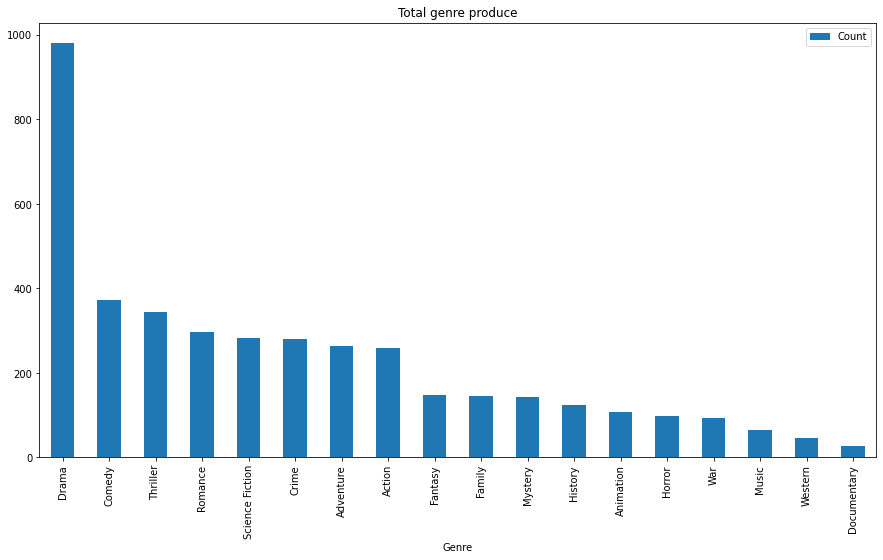

In [18]:
# afficher le graph 
data = df_genre_count.sort_values(by=["Count"], ascending=False)
data.plot(x="Genre",
  y="Count",
  kind="bar",
  title="Total genre produce",
  figsize=(15,8)
)

On constate que le Drama est loin devant. Cela peut s'expliquer par le fait que souvent ce dernier est associé à plusieurs autres catégories pour un même film. 

In [19]:
# fct pour convertir budget et revenu.
def convert_profit(nbr_str):
  result = 0
  exposant = 0
  for i in range(1, len(nbr_str) + 1):
    if nbr_str[-i] != "," and nbr_str[-i] != "$":
      result = result + ( int(nbr_str[-i]) *10**exposant)
      exposant += 1
  return result
# fct pour rajouter la conversion en int du budget et du revenu dans le dataframe
def convert_all_profit():
  budget = df_rate_7.Budget
  revenu = df_rate_7.Revenu
  list_budget, list_revenu = [],[]
  for i in budget:
    nbr = convert_profit(i)
    list_budget.append(nbr)
  for i in revenu:
    nbr = convert_profit(i)
    list_revenu.append(nbr)
  df_rate_7["Budget_int"] = list_budget
  df_rate_7["Revenu_int"] = list_revenu
convert_all_profit()    # ajout des deux colonnes
#df_rate_7.to_excel("df_rate_7_ok.xlsx") # transformer en excel 
def month_name():
  dico_month = {"01": "Jan",
                "02": "Fev",
                "03": "Mar",
                "04": "Apr",
                "05": "May",
                "06": "Jun",
                "07": "Jul",
                "08": "Aug",
                "09": "Sep",
                "10": "Oct",
                "11": "Nov",
                "12": "Dec"
  }
  list_month_name = []
  for date in df_rate_7["Realease Date"]:
    data = date[:2]
    name = dico_month[data]
    list_month_name.append(name)
  df_rate_7["Month"] = list_month_name
#month_name() # ajout des noms de mois 
df_rate_7

<ipython-input-19-c9b1e0e98655>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rate_7["Budget_int"] = list_budget
<ipython-input-19-c9b1e0e98655>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rate_7["Revenu_int"] = list_revenu


,Movie_id,Title,Summary,Rate,Year,Realease Date,Duration (min),Genre,Director,Actor,Budget,Revenu,Budget_int,Revenu_int
0,1,Toy Story,"Led by Woody, Andy's toys live happily in his ...",8.0,1995,11/22/1995,81,"['Animation', 'Adventure', 'Family', 'Comedy']",John Lasseter,"['Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim...","$30,000,000","$373,554,033",30000000,373554033
1,2,Jumanji,When siblings Judy and Peter discover an encha...,7.2,1995,03/28/1996,104,"['Adventure', 'Fantasy', 'Family']",Joe Johnston,"['Robin Williams', 'Kirsten Dunst', 'Bradley P...","$65,000,000","$262,821,940",65000000,262821940
5,6,Heat,Obsessive master thief Neil McCauley leads a t...,7.9,1995,12/15/1995,170,"['Action', 'Crime', 'Drama', 'Thriller']",Michael Mann,"['Al Pacino', 'Robert De Niro', 'Val Kilmer', ...","$60,000,000","$187,436,818",60000000,187436818
12,13,Balto,An outcast half-wolf risks his life to prevent...,7.3,1995,12/22/1995,78,"['Family', 'Animation', 'Adventure']",Elana Lesser,"['Kevin Bacon', 'Bob Hoskins', 'Bridget Fonda'...","$31,000,000","$11,348,324",31000000,11348324
15,16,Casino,"In early-1970s Las Vegas, Sam ""Ace"" Rothstein ...",8.0,1995,11/22/1995,179,"['Crime', 'Drama']",Martin Scorsese,"['Robert De Niro', 'Sharon Stone', 'Joe Pesci'...","$52,000,000","$116,112,375",52000000,116112375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9084,159858,The Conjuring 2,Lorraine and Ed Warren travel to north London ...,7.3,2016,06/08/2016,134,"['Horror', 'Thriller']",James Wan,"['Patrick Wilson', 'Vera Farmiga', 'Madison Wo...","$40,000,000","$320,392,818",40000000,320392818
9096,160954,Nerve,Industrious high school senior Vee Delmonico h...,7.1,2016,07/27/2016,96,"['Mystery', 'Adventure', 'Crime']",Henry Joost,"['Emma Roberts', 'Dave Franco', 'Emily Meade',...","$19,000,000","$85,241,496",19000000,85241496
9100,161582,Hell or High Water,A divorced dad and his ex-con brother resort t...,7.3,2016,09/23/2016,102,"['Crime', 'Drama', 'Thriller', 'Western']",David Mackenzie,"['Jeff Bridges', 'Chris Pine', 'Ben Foster', '...","$12,000,000","$37,589,296",12000000,37589296
9106,162542,Rustom,A naval officer is devastated to learn about h...,7.0,2016,08/12/2016,148,"['Thriller', 'Drama', 'Crime']",Vipul K Rawal,"['Akshay Kumar', ""Ileana D'Cruz"", 'Esha Gupta'...","$6,114,349","$26,309,214",6114349,26309214


In [20]:
# la foct qui vient juste après permet de résoudre ce problème 
# les genres dans le df ne sont pas bien mi dans la liste
x = df_rate_7.Genre
for genre_1 in x:
  print(genre_1)
  print(genre_1[-1])

['Animation', 'Adventure', 'Family', 'Comedy']
]
['Adventure', 'Fantasy', 'Family']
]
['Action', 'Crime', 'Drama', 'Thriller']
]
['Family', 'Animation', 'Adventure']
]
['Crime', 'Drama']
]
['Drama', 'Romance']
]
['Drama', 'Romance']
]
['Fantasy', 'Science Fiction', 'Adventure']
]
['Drama']
]
['Science Fiction', 'Thriller', 'Mystery']
]
['Drama']
]
['Comedy', 'Romance']
]
['Crime', 'Mystery', 'Thriller']
]
['Drama', 'Crime', 'Thriller']
]
['Drama', 'Music', 'Family']
]
['Comedy']
]
['Horror', 'Action', 'Thriller', 'Crime']
]
['Drama']
]
['Drama', 'Romance']
]
['Action', 'Drama', 'History', 'War']
]
['Crime', 'Drama']
]
['Comedy']
]
['Drama', 'Crime']
]
['History', 'Drama', 'Adventure']
]
['Thriller', 'Drama', 'Action']
]
['Action', 'Thriller']
]
['Comedy']
]
['Comedy', 'Drama']
]
['Crime', 'Drama', 'Science Fiction', 'Thriller']
]
['Drama', 'Romance']
]
['Drama']
]
['Drama', 'Romance']
]
['Comedy']
]
['Comedy', 'Drama', 'History']
]
['Romance', 'Animation', 'Family', 'Comedy', 'Adventur

In [21]:
# code à ne lancer qu'un fois !!!
# sinon on relance tout les code de la partie 2 pour réparer ça
# fct qui nous permet de fixer les anomalie de la colonnes Genre
def get_right_genre():
  result = []   # c'est cette list qui va remplacer la liste de genre de base qui est mal fait
  genre = df_rate_7.Genre
  for data in genre:
    list_genre = []
    list_1 = data.split(",")    # une fois le code exécuter une fois on ne le relance pas 
    for data in list_1:
      word = ""
      for element in data:
        if element != "'" and element != "[" and element != "]":
          word += element
      list_genre.append(word)
    result.append(list_genre)
  return result
#a = get_right_genre()   # j'ai tout les genres
#df_rate_7.Genre = df_rate_7["Genre"] = a  # je remplace dans la df de base
#df_rate_7.to_excel("df_rate_7_ok.xlsx")  # je téclécharge le fichier
# calculer le benf 
def get_benef():
  result = []   # on va renvoie une liste avec les bénéfices = Revenu_int - Budget_int
  budget = list(df_rate_7.Budget_int)
  revenu = list(df_rate_7.Revenu_int)
  for i in range(len(budget)):
    benef = revenu[i] - budget[i]
    result.append(benef)
  return result
a = get_benef()
#print(a)
df_rate_7["Profit"] = a
#df_rate_7.to_excel("df_rate_7_ok.xlsx")  # je téclécharge le fichier
list_genre_2 = get_right_genre()
df_rate_7["Genre"] = list_genre_2
df_rate_7

<ipython-input-21-f46daa1a679b>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rate_7["Profit"] = a
<ipython-input-21-f46daa1a679b>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rate_7["Genre"] = list_genre_2


,Movie_id,Title,Summary,Rate,Year,Realease Date,Duration (min),Genre,Director,Actor,Budget,Revenu,Budget_int,Revenu_int,Profit
0,1,Toy Story,"Led by Woody, Andy's toys live happily in his ...",8.0,1995,11/22/1995,81,"[Animation, Adventure, Family, Comedy]",John Lasseter,"['Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim...","$30,000,000","$373,554,033",30000000,373554033,343554033
1,2,Jumanji,When siblings Judy and Peter discover an encha...,7.2,1995,03/28/1996,104,"[Adventure, Fantasy, Family]",Joe Johnston,"['Robin Williams', 'Kirsten Dunst', 'Bradley P...","$65,000,000","$262,821,940",65000000,262821940,197821940
5,6,Heat,Obsessive master thief Neil McCauley leads a t...,7.9,1995,12/15/1995,170,"[Action, Crime, Drama, Thriller]",Michael Mann,"['Al Pacino', 'Robert De Niro', 'Val Kilmer', ...","$60,000,000","$187,436,818",60000000,187436818,127436818
12,13,Balto,An outcast half-wolf risks his life to prevent...,7.3,1995,12/22/1995,78,"[Family, Animation, Adventure]",Elana Lesser,"['Kevin Bacon', 'Bob Hoskins', 'Bridget Fonda'...","$31,000,000","$11,348,324",31000000,11348324,-19651676
15,16,Casino,"In early-1970s Las Vegas, Sam ""Ace"" Rothstein ...",8.0,1995,11/22/1995,179,"[Crime, Drama]",Martin Scorsese,"['Robert De Niro', 'Sharon Stone', 'Joe Pesci'...","$52,000,000","$116,112,375",52000000,116112375,64112375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9084,159858,The Conjuring 2,Lorraine and Ed Warren travel to north London ...,7.3,2016,06/08/2016,134,"[Horror, Thriller]",James Wan,"['Patrick Wilson', 'Vera Farmiga', 'Madison Wo...","$40,000,000","$320,392,818",40000000,320392818,280392818
9096,160954,Nerve,Industrious high school senior Vee Delmonico h...,7.1,2016,07/27/2016,96,"[Mystery, Adventure, Crime]",Henry Joost,"['Emma Roberts', 'Dave Franco', 'Emily Meade',...","$19,000,000","$85,241,496",19000000,85241496,66241496
9100,161582,Hell or High Water,A divorced dad and his ex-con brother resort t...,7.3,2016,09/23/2016,102,"[Crime, Drama, Thriller, Western]",David Mackenzie,"['Jeff Bridges', 'Chris Pine', 'Ben Foster', '...","$12,000,000","$37,589,296",12000000,37589296,25589296
9106,162542,Rustom,A naval officer is devastated to learn about h...,7.0,2016,08/12/2016,148,"[Thriller, Drama, Crime]",Vipul K Rawal,"['Akshay Kumar', ""Ileana D'Cruz"", 'Esha Gupta'...","$6,114,349","$26,309,214",6114349,26309214,20194865


In [22]:
#df_rate_7.to_excel("df_rate_7_ok.xlsx")

In [23]:
# pour bien voir que le .Genre est bien dans une liste de manière correcte cette fois
x = df_rate_7.Genre
for genre_1 in x:
  print(genre_1)
  print(genre_1[-1])

['Animation', ' Adventure', ' Family', ' Comedy']
 Comedy
['Adventure', ' Fantasy', ' Family']
 Family
['Action', ' Crime', ' Drama', ' Thriller']
 Thriller
['Family', ' Animation', ' Adventure']
 Adventure
['Crime', ' Drama']
 Drama
['Drama', ' Romance']
 Romance
['Drama', ' Romance']
 Romance
['Fantasy', ' Science Fiction', ' Adventure']
 Adventure
['Drama']
Drama
['Science Fiction', ' Thriller', ' Mystery']
 Mystery
['Drama']
Drama
['Comedy', ' Romance']
 Romance
['Crime', ' Mystery', ' Thriller']
 Thriller
['Drama', ' Crime', ' Thriller']
 Thriller
['Drama', ' Music', ' Family']
 Family
['Comedy']
Comedy
['Horror', ' Action', ' Thriller', ' Crime']
 Crime
['Drama']
Drama
['Drama', ' Romance']
 Romance
['Action', ' Drama', ' History', ' War']
 War
['Crime', ' Drama']
 Drama
['Comedy']
Comedy
['Drama', ' Crime']
 Crime
['History', ' Drama', ' Adventure']
 Adventure
['Thriller', ' Drama', ' Action']
 Action
['Action', ' Thriller']
 Thriller
['Comedy']
Comedy
['Comedy', ' Drama']
 Dram

Ici on va faire regarder la note moyenne par genre

In [24]:
df_rate_7.Rate.unique()
x = df_rate_7.Rate.unique()
print("liste des notes : ",x)
print("note min :", min(x), "note max : ", max(x))

liste des notes :  [8.  7.2 7.9 7.3 7.5 7.  7.6 7.4 8.4 8.2 7.1 8.1 7.7 8.3 8.5 8.7 7.8 8.6]
note min : 7.0 note max :  8.7


In [25]:
# fct pour avoir la moyenne par genre 
# on va renvoyer une liste contenant le movie_id respectant la condition
def get_movie_id_by_genre(genre_name:str):
  list_genre = list(df_rate_7.Genre)
  list_id = list(df_rate_7.Movie_id)
  result = []     
  for i in range(len(list_id)):
    if genre_name in list_genre[i] or (" " + genre_name) in list_genre[i]:    # certains genre on des " " avant le nom du genre 
      result.append(list_id[i])
  return result
#fct reprenant la liste précédente pour créer une df avec uniquement les movie id correspondant
def get_mean_by_genre(list_movie_id):
  df = df_rate_7[df_rate_7.Movie_id.isin(list_movie_id)]
  all_note = 0
  for note in df.Rate:  # on va chercher la note de chaque ligne contenue dans le df
    all_note += note 
  count = len(df)   # pour la division
  #print(count)
  result = all_note/count
  return result
def mean():
  all_mean = []
  for i in list_genre:
    #print(i)
    id = get_movie_id_by_genre(i)
    mean = get_mean_by_genre(id)
    all_mean.append(mean)
  dic_mean = {}
  dic_mean["Genre"] = list_genre
  dic_mean["Mean"] = all_mean
  return dic_mean
a = mean()
print(a)
df_mean_by_genre = DataFrame(a)
df_mean_by_genre.sort_values(by=["Mean"], ascending=False) # note moyen par genre 

{'Genre': ['Animation', 'Adventure', 'Family', 'Comedy', 'Fantasy', 'Action', 'Crime', 'Drama', 'Thriller', 'Romance', 'Science Fiction', 'Mystery', 'Music', 'Horror', 'History', 'War', 'Documentary', 'Western'], 'Mean': [7.473148148148147, 7.406818181818185, 7.377931034482762, 7.35456989247311, 7.453741496598639, 7.401930501930501, 7.463701067615656, 7.45173469387756, 7.404081632653057, 7.404054054054054, 7.438297872340427, 7.4535211267605685, 7.413846153846155, 7.327835051546392, 7.460483870967743, 7.5720430107526875, 7.444444444444444, 7.463829787234044]}


,Genre,Mean
15,War,7.572043
0,Animation,7.473148
17,Western,7.463830
6,Crime,7.463701
14,History,7.460484
4,Fantasy,7.453741
11,Mystery,7.453521
7,Drama,7.451735
16,Documentary,7.444444
10,Science Fiction,7.438298


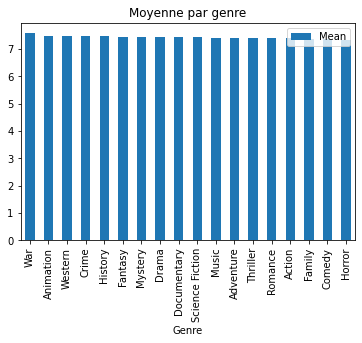

In [26]:
x = df_mean_by_genre.sort_values(by=["Mean"], ascending=False)
x.plot(x="Genre",
  y="Mean",
  kind="bar",
  title="Moyenne par genre"
)

# Partie 4a Anlyse du genre Drama


In [27]:
# création de la df_drama
id = get_movie_id_by_genre("Drama")
df_drama = df_rate_7[df_rate_7.Movie_id.isin(id)]
df_drama

,Movie_id,Title,Summary,Rate,Year,Realease Date,Duration (min),Genre,Director,Actor,Budget,Revenu,Budget_int,Revenu_int,Profit
5,6,Heat,Obsessive master thief Neil McCauley leads a t...,7.9,1995,12/15/1995,170,"[Action, Crime, Drama, Thriller]",Michael Mann,"['Al Pacino', 'Robert De Niro', 'Val Kilmer', ...","$60,000,000","$187,436,818",60000000,187436818,127436818
15,16,Casino,"In early-1970s Las Vegas, Sam ""Ace"" Rothstein ...",8.0,1995,11/22/1995,179,"[Crime, Drama]",Martin Scorsese,"['Robert De Niro', 'Sharon Stone', 'Joe Pesci'...","$52,000,000","$116,112,375",52000000,116112375,64112375
16,17,Sense and Sensibility,Based on Jane Austen's classic novel of the Da...,7.5,1995,02/23/1996,136,"[Drama, Romance]",Ang Lee,"['Emma Thompson', 'Kate Winslet', 'Alan Rickma...","$16,000,000","$134,582,776",16000000,134582776,118582776
24,25,Leaving Las Vegas,"Ben Sanderson, an alcoholic Hollywood screenwr...",7.3,1995,10/27/1995,111,"[Drama, Romance]",Mike Figgis,"['Nicolas Cage', 'Elisabeth Shue', 'Julian San...","$3,600,000","$49,800,000",3600000,49800000,46200000
30,31,Dangerous Minds,Former Marine Louanne Johnson lands a gig teac...,7.0,1995,08/11/1995,99,[Drama],John N. Smith,"['Michelle Pfeiffer', 'George Dzundza', 'Court...","$23,000,000","$179,519,401",23000000,179519401,156519401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9055,152077,10 Cloverfield Lane,"After getting in a car accident, a woman is he...",7.0,2016,04/01/2016,104,"[Thriller, Science Fiction, Drama, Horror]",Matthew Stuecken,"['Mary Elizabeth Winstead', 'John Goodman', 'J...","$15,000,000","$108,286,421",15000000,108286421,93286421
9067,156387,Sing Street,A boy growing up in Dublin during the 1980s es...,7.9,2016,04/15/2016,106,"[Comedy, Romance, Drama, Music]",John Carney,"['Ferdia Walsh-Peelo', 'Lucy Boynton', 'Maria ...","$4,000,000","$13,624,522",4000000,13624522,9624522
9078,158783,The Handmaiden,"In 1930s Korea, a new girl is hired as a handm...",8.3,2016,06/24/2016,145,"[Thriller, Drama, Romance]",Park Chan-wook,"['Kim Min-hee', 'Kim Tae-ri', 'Ha Jung-woo', '...","$8,575,000","$37,767,206",8575000,37767206,29192206
9100,161582,Hell or High Water,A divorced dad and his ex-con brother resort t...,7.3,2016,09/23/2016,102,"[Crime, Drama, Thriller, Western]",David Mackenzie,"['Jeff Bridges', 'Chris Pine', 'Ben Foster', '...","$12,000,000","$37,589,296",12000000,37589296,25589296


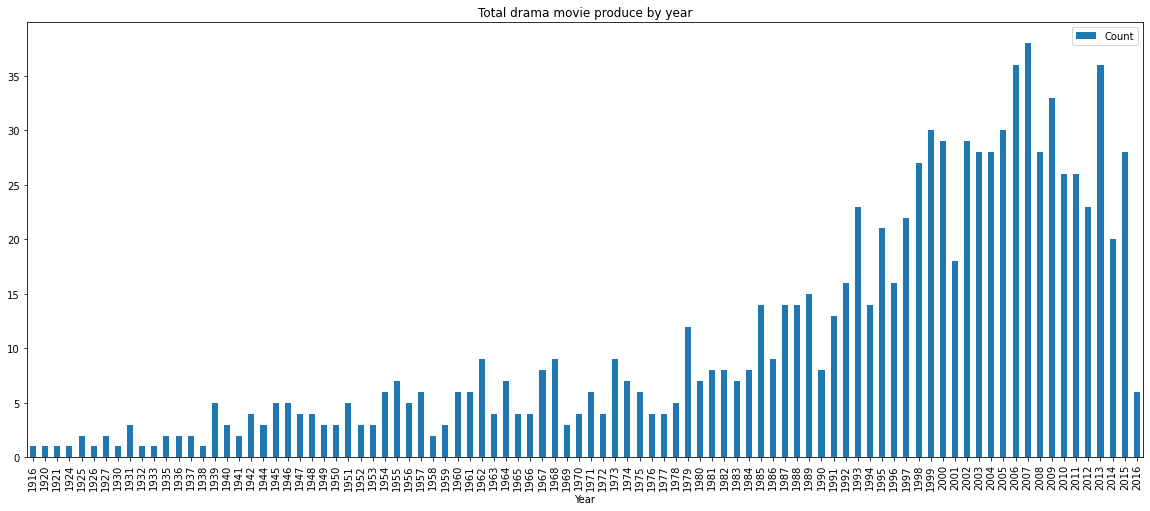

In [28]:
# nbr de drama par an
def nbr_drama_year():
  list_year = list(df_drama.Year.unique())
  list_count = []
  for year_1 in list_year:
    count = 0
    for year_2 in list(df_drama.Year):
      if year_2 == year_1:
        count +=1
    list_count.append(count)
  dict_result = {}
  dict_result["Year"] = list_year
  dict_result["Count"] = list_count
  df = DataFrame(dict_result)
  x = df.sort_values(by=["Year"], ascending=True)
  return x
a = nbr_drama_year() # contient le df
a.plot.bar(x="Year", y="Count",  title="Total drama movie produce by year",figsize=(20,8))

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


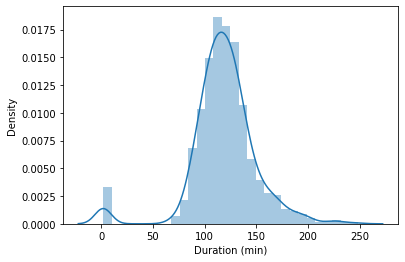

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

x = df_drama["Duration (min)"]
sns.distplot(x, bins=30)    # loi normal 

In [30]:
df_drama.to_excel("df_drama.xlsx")

In [31]:
# fct pour calculer les genres relié au drama
def nbr_genre_sec():
  df_genre = df_drama.Genre   # c'est une liste
  list_count, list_result = [], []    # list result va contenir les genres relié à Drama
  for genre_1 in list_genre:
    count = 0
    if genre_1 != "Drama":
      for data in df_genre:   # liste de genre
        for genre_2 in data:
          if genre_1 == genre_2 or " " + genre_1 == genre_2:    # ne pas oublier que le genre peut être écris avec un espace
            count +=1
      list_count.append(count)
      list_result.append(genre_1)
  dic_result = {}
  dic_result["Genre"] = list_result
  dic_result["Count"] = list_count
  return dic_result
x = nbr_genre_sec()
df_genre_sec = DataFrame(x)
df_genre_sec.sort_values(by=["Count"], ascending=False)
#.sort_values(by=["Count"], ascending=False)

,Genre,Count
8,Romance,230
7,Thriller,206
6,Crime,191
3,Comedy,176
13,History,116
5,Action,92
10,Mystery,81
1,Adventure,80
14,War,76
4,Fantasy,44


On va s'intéressé aux thèmes des top 3 genres associé au drama. 

- Romance 
- Thriller
- Crime

# Partie 4b Thèmatique

- Romance 
- Thriller
- Crime

In [32]:
def get_movie_id_by_genre_2(genre_name:str):
  list_genre = list(df_drama.Genre)
  list_id = list(df_drama.Movie_id)
  result = []     
  for i in range(len(list_id)):
    if genre_name in list_genre[i] or (" " + genre_name) in list_genre[i]:    # certains genre on des " " avant le nom du genre 
      result.append(list_id[i])
  return result

In [33]:
# création de la df_drama_romance
id = get_movie_id_by_genre_2("Romance")
df_drama_romance = df_drama[df_drama.Movie_id.isin(id)]
# création de la df_drama_thriller
id = get_movie_id_by_genre_2("Thriller")
df_drama_thriller = df_drama[df_drama.Movie_id.isin(id)]
# création de la df_drama_crime
id = get_movie_id_by_genre_2("Crime")
df_drama_crime = df_drama[df_drama.Movie_id.isin(id)]
# pour les téclécharger
#df_drama_romance.to_excel("df_drama_Romance.xlsx")
#df_drama_thriller.to_excel("df_drama_Thriller.xlsx")
#df_drama_crime.to_excel("df_drama_crime.xlsx")

on va enregistrer les résumés de chaque sous genre dans une variable 

In [34]:
sum_romance, sum_thriller, sum_crime = "", "", ""   # variable contenant les résumé
x = df_drama_romance.Summary
for i in x:
  sum_romance = sum_romance + i + " "
print(sum_romance)

x = df_drama_thriller.Summary
for i in x:
  sum_thriller = sum_thriller + i + " "
print(sum_thriller)

x = df_drama_crime.Summary
for i in x:
  sum_crime = sum_crime + i + " "
print(sum_crime)

# on va aussi observer les movies qui on juste drama comme genre sans rien associé à eux.
sum_drama = ""
x = list(df_drama.Genre)
y = list(df_drama.Summary)
for i in range(len(x)):
  if len(x[i]) == 1:    # ça veut dire que c'est une "Drama" uniquement
    sum_drama = sum_drama + y[i] + " "
print(sum_drama)

Based on Jane Austen's classic novel of the Dashwood sisters, sensible Elinor and passionate Marianne, whose chances at marriage seem doomed by their family's sudden loss of fortune.  When Henry Dashwood dies unexpectedly, his estate must pass on by law to his son from his first marriage, John and wife Fanny. But these circumstances leave Mr. Dashwood's current wife, and daughters Elinor, Marianne and Margaret, without a home and with barely enough money to live on. As Elinor and Marianne struggle to find romantic fulfillment in a society obsessed with financial and social status, they must learn to mix sense with sensibility in their dealings with both money and men. Ben Sanderson, an alcoholic Hollywood screenwriter who lost everything because of his drinking, arrives in Las Vegas to drink himself to death. There, he meets and forms an uneasy friendship and non-interference pact with prostitute Sera. Photographer Robert Kincaid wanders into the life of housewife Francesca Johnson for

On va passer à l'analyse des résumés de chaque sous genre ansi que de des genres drama uniquement. 

In [35]:
import nltk
from nltk.corpus import stopwords, words
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


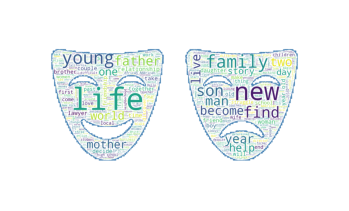

In [36]:
my_mask = np.array(Image.open("/content/drive/MyDrive/UCL/Cours/M1/Q1/P2/Web Mining/Projet/Data/drama.webp"))

cloud = WordCloud(background_color='white', max_words=2000, contour_width=3, contour_color='steelblue', mask = my_mask).generate(sum_drama)

plt.imshow(cloud)
plt.axis("off")
plt.show()
cloud.to_file("sum_Drama.jpg")

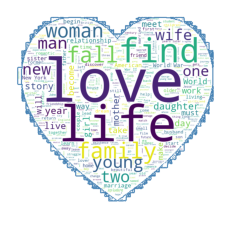

In [37]:
my_mask = np.array(Image.open("/content/drive/MyDrive/UCL/Cours/M1/Q1/P2/Web Mining/Projet/Data/coeur.png"))

cloud = WordCloud(background_color='white', max_words=2000, contour_width=3, contour_color='steelblue', mask = my_mask).generate(sum_romance)

plt.imshow(cloud)
plt.axis("off")
plt.show()
cloud.to_file("sum_Romance.jpg")

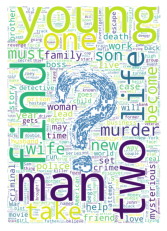

In [38]:
my_mask = np.array(Image.open("/content/drive/MyDrive/UCL/Cours/M1/Q1/P2/Web Mining/Projet/Data/mark.jpeg"))

cloud = WordCloud(background_color='white', max_words=2000, contour_width=3, contour_color='steelblue', mask = my_mask).generate(sum_thriller)

plt.imshow(cloud)
plt.axis("off")
plt.show()
cloud.to_file("sum_Triller.jpg")

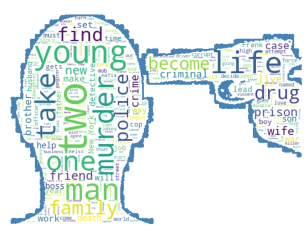

In [39]:
my_mask = np.array(Image.open("/content/drive/MyDrive/UCL/Cours/M1/Q1/P2/Web Mining/Projet/Data/crime.jpeg"))

cloud = WordCloud(background_color='white', max_words=2000, contour_width=3, contour_color='steelblue', mask = my_mask).generate(sum_crime)

plt.imshow(cloud)
plt.axis("off")
plt.show()
cloud.to_file("sum_Crime.jpg")

# Patie 5a top 20 des réalisateurs 

In [40]:
df = df_drama[["Director","Profit"]]
df

,Director,Profit
5,Michael Mann,127436818
15,Martin Scorsese,64112375
16,Ang Lee,118582776
24,Mike Figgis,46200000
30,John N. Smith,156519401
...,...,...
9055,Matthew Stuecken,93286421
9067,John Carney,9624522
9078,Park Chan-wook,29192206
9100,David Mackenzie,25589296


In [41]:
x = df_drama.Director.unique()    # list des réalisateurs
print("Total réalisateur :",len(x))
list_director_name = list(x)


Total réalisateur : 587


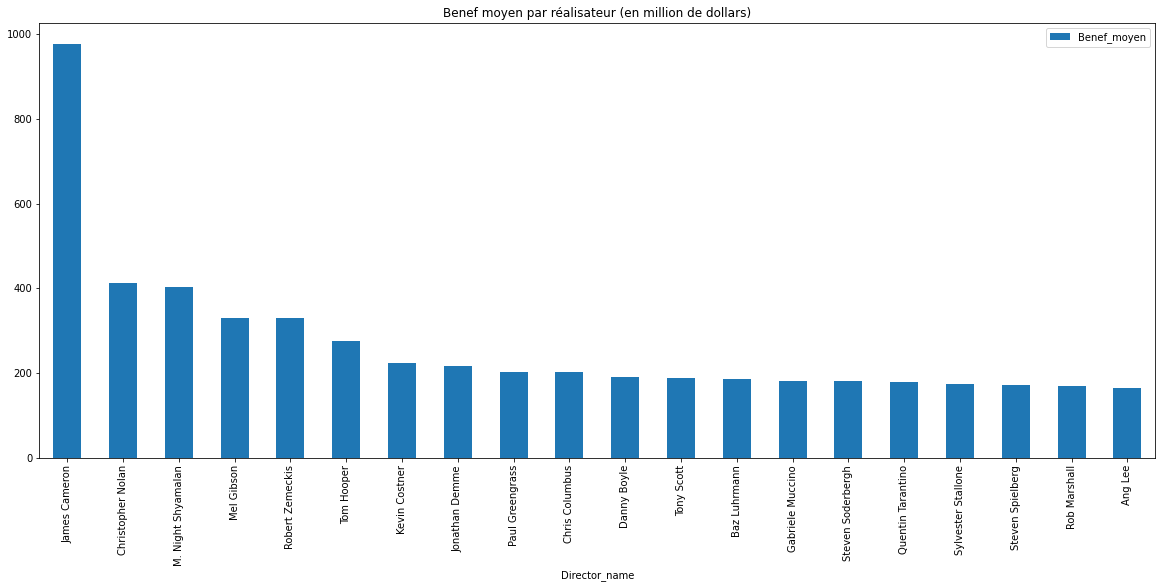

In [42]:
#rate_7_min = df_2.Rate >= 7
#print(rate_7_min)
#df_rate_7 = df_2[rate_7_min]  
def get_one_director_profit(director_name):
  condition = df.Director == director_name    # on cherche les ligne contenant le nom du directeur
  df_new = df[condition]   
  count, somme = 0, 0
  for nb in df_new.Profit:
    count += 1
    somme += nb
  moyenne = (somme / count) / 1000000   # exprimé en million
  return moyenne, count 
#a = get_director_profit("Michael Mann")
#print(a)
def get_all_director_profit():    #on va return la moyenne de chaque directeur dans une liste et le nbr de film
  list_moyenne, list_count = [], []
  for name in list_director_name:
    data = get_one_director_profit(name)
    list_moyenne.append(data[0])  # on ajoute la moyenne à la liste
    list_count.append(data[1])    # on ajoute le nbr de films qu'il a tourné
  return list_moyenne, list_count
def graph_moyenne_director_profit():
  dic_result = {}
  data = get_all_director_profit()
  dic_result["Director_name"] = list_director_name
  dic_result["Benef_moyen"] = data[0]
  dic_result["nbr_film"] = data[1]

  df_result = DataFrame(dic_result)    # dans une dataframe
  return df_result
x = graph_moyenne_director_profit()
a = x.sort_values(by=["Benef_moyen"], ascending=False)
#a.plot.bar(x="Director_name", y="Benef_moyen",  title="Benef moyen par directeur",figsize=(50,8))
y = a.query("nbr_film >= 2").head(20)   # condition pour n'avoir que les réalisateurs ayant fait au moins 2 film 
y.plot.bar(x="Director_name", y="Benef_moyen",  title="Benef moyen par réalisateur (en million de dollars)",figsize=(20,8))

In [43]:
y # contient les 20 premiers réalisateurs 

,Director_name,Benef_moyen,nbr_film
15,James Cameron,976.711617,2
211,Christopher Nolan,413.544400,6
223,M. Night Shyamalan,402.962206,2
364,Mel Gibson,331.276879,2
34,Robert Zemeckis,329.400600,3
508,Tom Hooper,276.404281,3
56,Kevin Costner,224.252570,2
48,Jonathan Demme,217.210681,2
379,Paul Greengrass,202.850565,4
45,Chris Columbus,201.855028,2


In [44]:
list_director_name_20 = list(y.Director_name)
print(list_director_name_20)
print(len(list_director_name_20))

['James Cameron', 'Christopher Nolan', 'M. Night Shyamalan', 'Mel Gibson', 'Robert Zemeckis', 'Tom Hooper', 'Kevin Costner', 'Jonathan Demme', 'Paul Greengrass', 'Chris Columbus', 'Danny Boyle', 'Tony Scott', 'Baz Luhrmann', 'Gabriele Muccino', 'Steven Soderbergh', 'Quentin Tarantino', 'Sylvester Stallone', 'Steven Spielberg', 'Rob Marshall', 'Ang Lee']
20


# Partie 5b Construction du réseaux réalisateurs et acteurs

le réseau des réalisateurs et acteurs se fait sur base des 50 premiers réalisateurs 


In [45]:
# code a ne lancer qu'un fois 
def get_right_actor():    # même concept que get_right_genre
  result = []   # c'est cette list qui va remplacer la liste des acteurs de base qui est mal fait
  genre = df_drama.Actor
  for data in genre:
    list_genre = []
    list_1 = data.split(",")    # une fois le code exécuter une fois on ne le relance pas 
    for data in list_1:
      word = ""
      for element in data:
        if element != "'" and element != "[" and element != "]":
          word += element
      list_genre.append(word)
    result.append(list_genre)
  return result

a = get_right_actor()   # j'ai l'ensemble des acteurs
df_drama.Actor = df_drama["Actor"] = a  # je remplace dans la df de base

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-45-8b7a79b24ee4>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drama.Actor = df_drama["Actor"] = a  # je remplace dans la df de base


In [46]:
from pandas.core.internals.construction import dict_to_mgr
# code à faire après avoir appellé la fct get_right_actor()
# ne pas oublier que get_right_actor() doit être appellé qu'une seule fois 

# fct pour créer un dico avec le nom des réalisateurs comme key et leur id en value / id commence à 0
def make_dic_director_name_id():
  dico_director_name_id = {}   # on va return ce dico à la fin
  id = 0
  for name in list_director_name_20:
    dico_director_name_id[name] = id
    id +=1
  return dico_director_name_id, id

# la foct va construire un dico avec le nom des acteur comme key et leur id comme value / id reprend à la fin de id des realisateurs
def make_dico_actor_name_id(id_start): # ici on va récupérer le laisser par la fct dic_director_name_id
  id = id_start
  list_actor_name, dico_actor_name_id = [], {}  # création de list et dico pour les nom d'acteur
  df = df_drama.Actor
  for data_list in df:      # ici on a une list qui contient des noms d'acteur pour un film 
    for name in data_list:  # ici on a chaque nom de la liste
      if name not in list_actor_name:
        dico_actor_name_id[name] = id   # on le rajoute dnas le dico
        list_actor_name.append(name)     # on le rajoute à la liste des noms
        id +=1
  return dico_actor_name_id

# fct pour créer les nodes 
def make_list_all_node_gephi():
  dico_result = {}     # utile pour la dataframe que l'on va renvoyer
  list_id, list_label = [], []     # idem 
  data_director = make_dic_director_name_id() # contient dico et id
  data_actor = make_dico_actor_name_id(data_director[1])  # idem
  for k, v in data_director[0].items():
    list_id.append(v)
    list_label.append(k)
  for k, v in data_actor.items():
    list_id.append(v)
    list_label.append(k)
  # création du file d'enregistrement
  dico_result["Id"] = list_id
  dico_result["Label"] = list_label
  df = DataFrame(dico_result)
  return df, data_director[0], data_actor    # data_d et data_actor sont les dictionnaires avec key = name et value = id 
x = make_list_all_node_gephi()
df_node_file = x[0]
dic_director_name_id = x[1]
dic_actor_name_id = x[2]

#df_node_file.to_excel("all_node_gephi.xlsx")   # télécharger on va le retransformer en csv dans excel pour enlever les indexes qui posent problème dans gephi
df_node_file

,Id,Label
0,0,James Cameron
1,1,Christopher Nolan
2,2,M. Night Shyamalan
3,3,Mel Gibson
4,4,Robert Zemeckis
...,...,...
6148,6148,Usha Nadkarni
6149,6149,Sachin Khedekar
6150,6150,Kumud Mishra
6151,6151,Anang Desai


In [47]:
# création de dic_actor_id_name, dic_director_id_name
dic_actor_id_name, dic_director_id_name = {}, {}
for k,v in dic_director_name_id.items():
  dic_director_id_name[v] = k
for k,v in dic_actor_name_id.items():
  dic_actor_id_name[v] = k
print(dic_director_id_name)
print(dic_actor_id_name)

{0: 'James Cameron', 1: 'Christopher Nolan', 2: 'M. Night Shyamalan', 3: 'Mel Gibson', 4: 'Robert Zemeckis', 5: 'Tom Hooper', 6: 'Kevin Costner', 7: 'Jonathan Demme', 8: 'Paul Greengrass', 9: 'Chris Columbus', 10: 'Danny Boyle', 11: 'Tony Scott', 12: 'Baz Luhrmann', 13: 'Gabriele Muccino', 14: 'Steven Soderbergh', 15: 'Quentin Tarantino', 16: 'Sylvester Stallone', 17: 'Steven Spielberg', 18: 'Rob Marshall', 19: 'Ang Lee'}
{20: 'Al Pacino', 21: ' Robert De Niro', 22: ' Val Kilmer', 23: ' Jon Voight', 24: ' Tom Sizemore', 25: ' Diane Venora', 26: ' Amy Brenneman', 27: ' Ashley Judd', 28: ' Kevin Gage', 29: 'Robert De Niro', 30: ' Sharon Stone', 31: ' Joe Pesci', 32: ' Don Rickles', 33: ' James Woods', 34: ' Alan King', 35: ' Kevin Pollak', 36: ' Pasquale Cajano', 37: ' L.Q. Jones', 38: 'Emma Thompson', 39: ' Kate Winslet', 40: ' Alan Rickman', 41: ' Hugh Grant', 42: ' Gemma Jones', 43: ' Greg Wise', 44: ' Elizabeth Spriggs', 45: ' Imogen Stubbs', 46: ' Harriet Walter', 47: 'Nicolas Cage'

In [48]:
# fct utile pour créer les edges pour gephi 

def get_df_actor_for_director(director_name:str):
  condition = df_drama.Director == director_name
  df = df_drama[condition]
  return df

# fct pour créer les edges pour gephi 
def make_list_alle_edge_gephi():
  list_source, list_target, list_id = [], [], []
  id_edge = 0
  for name_d in list_director_name_20:
    df_director = get_df_actor_for_director(name_d) # voir fct get_df_actor_for_director() renvoir un df pour le directeur recherché
    for data_list in df_director.Actor:
      for name_a in data_list:
        source_id = dic_director_name_id[name_d]
        target_id = dic_actor_name_id[name_a]
        list_source.append(source_id)
        list_target.append(target_id)
        list_id.append(id_edge)
        id_edge += 1
  # inverser l'id avec le nom coressondant
  #print(list_source)
  list_source_2, list_target_2 = [], []
  for id in list_source :
    name = dic_director_id_name[id]
    list_source_2.append(name)
  for id in list_target :
    name = dic_actor_id_name[id]
    list_target_2.append(name)
  #print(list_source_2)
  dic_result = {
      "Source": list_source_2,
      "Target": list_target_2,
      "Label": list_id
  }
  df = DataFrame(dic_result)
  return df
df_edge = make_list_alle_edge_gephi()
#df_edge.to_excel("all_edge_gephi.xlsx")
df_edge

,Source,Target,Label
0,James Cameron,Ralph Fiennes,0
1,James Cameron,Angela Bassett,1
2,James Cameron,Juliette Lewis,2
3,James Cameron,Tom Sizemore,3
4,James Cameron,Michael Wincott,4
...,...,...,...
571,Ang Lee,Adil Hussain,571
572,Ang Lee,Tabu,572
573,Ang Lee,Ayaan Khan,573
574,Ang Lee,Mohd Abbas Khaleeli,574


Closeness Centrality:

Steven Spielberg 0.35 et Christopher Nolan 0.266 sortent du lot. Dans le classement nous avons principalement des acteurs. 

Création réseau acteur uniquement 

In [49]:
df_drama.head()

,Movie_id,Title,Summary,Rate,Year,Realease Date,Duration (min),Genre,Director,Actor,Budget,Revenu,Budget_int,Revenu_int,Profit
5,6,Heat,Obsessive master thief Neil McCauley leads a t...,7.9,1995,12/15/1995,170,"[Action, Crime, Drama, Thriller]",Michael Mann,"[Al Pacino, Robert De Niro, Val Kilmer, Jon...","$60,000,000","$187,436,818",60000000,187436818,127436818
15,16,Casino,"In early-1970s Las Vegas, Sam ""Ace"" Rothstein ...",8.0,1995,11/22/1995,179,"[Crime, Drama]",Martin Scorsese,"[Robert De Niro, Sharon Stone, Joe Pesci, D...","$52,000,000","$116,112,375",52000000,116112375,64112375
16,17,Sense and Sensibility,Based on Jane Austen's classic novel of the Da...,7.5,1995,02/23/1996,136,"[Drama, Romance]",Ang Lee,"[Emma Thompson, Kate Winslet, Alan Rickman, ...","$16,000,000","$134,582,776",16000000,134582776,118582776
24,25,Leaving Las Vegas,"Ben Sanderson, an alcoholic Hollywood screenwr...",7.3,1995,10/27/1995,111,"[Drama, Romance]",Mike Figgis,"[Nicolas Cage, Elisabeth Shue, Julian Sands,...","$3,600,000","$49,800,000",3600000,49800000,46200000
30,31,Dangerous Minds,Former Marine Louanne Johnson lands a gig teac...,7.0,1995,08/11/1995,99,[Drama],John N. Smith,"[Michelle Pfeiffer, George Dzundza, Courtney...","$23,000,000","$179,519,401",23000000,179519401,156519401


In [50]:
list_actor_name = ["Leonardo DiCaprio", "Tom Hanks", "Anne Hathaway", "Barry Pepper", "Catherine Zeta-Jones", "Irrfan Khan","Morgan Freeman", "Matthew McConaughey","Christian Bale", "Liam Neeson", "Geoffrey Rush","Sebastian Koch","Ralph Fiennes","Tom Sizemore","Haley Joel Osment", "Matt Damon"]
print("Total best actor : ", len(list_actor_name))

Total best actor :  16


In [51]:
#construction de al liste d'acteur 
def make_list_actor():
  list_actor_name = []
  for data_list in df_drama.Actor:
    for name in data_list:
      if name not in list_actor_name:
        list_actor_name.append(name)
  return list_actor_name
list_actor_name_all = make_list_actor()
print(list_actor_name_all)
print("total acteur :",len(list_actor_name_all))

# fct qui se base sur les acteurs populaires apr§s l'analyse matrice realisateur et acteur 
def make_edge_actor_gephi():
  list_source, list_target, list_label =[], [], []
  id = 0
  for name_1 in list_actor_name:
    for data_list in df_drama.Actor:
      if name_1 in data_list:     # on vérifie que l'acteur est présent dans las liste 
        for name_2 in data_list:
          if name_2 != name_1:
            list_source.append(name_1)
            list_target.append(name_2)
            list_label.append(id)
            id +=1
  dic_result = {
      "Source": list_source,
      "Target": list_target,
      "Label": list_label
  }
  df = DataFrame(dic_result)
  return df
df_edge_actor_only = make_edge_actor_gephi()
#df_edge_actor_only.to_excel("all_edge_actor_only.xlsx")
df_edge_actor_only

['Al Pacino', ' Robert De Niro', ' Val Kilmer', ' Jon Voight', ' Tom Sizemore', ' Diane Venora', ' Amy Brenneman', ' Ashley Judd', ' Kevin Gage', 'Robert De Niro', ' Sharon Stone', ' Joe Pesci', ' Don Rickles', ' James Woods', ' Alan King', ' Kevin Pollak', ' Pasquale Cajano', ' L.Q. Jones', 'Emma Thompson', ' Kate Winslet', ' Alan Rickman', ' Hugh Grant', ' Gemma Jones', ' Greg Wise', ' Elizabeth Spriggs', ' Imogen Stubbs', ' Harriet Walter', 'Nicolas Cage', ' Elisabeth Shue', ' Julian Sands', ' Richard Lewis', ' Steven Weber', ' Kim Adams', ' Emily Procter', ' Stuart Regen', ' Valeria Golino', 'Michelle Pfeiffer', ' George Dzundza', ' Courtney B. Vance', ' Robin Bartlett', ' John Neville', ' Lorraine Toussaint', ' Renoly Santiago', ' Skye Bassett', ' Beatrice Winde', 'Susan Sarandon', ' Sean Penn', ' Robert Prosky', ' Raymond J. Barry', ' R. Lee Ermey', ' Celia Weston', ' Lois Smith', ' Scott Wilson', ' Roberta Maxwell', 'Gabriel Byrne', ' Stephen Baldwin', ' Kevin Spacey', ' Chazz P

,Source,Target,Label
0,Leonardo DiCaprio,Mark Wahlberg,0
1,Leonardo DiCaprio,Lorraine Bracco,1
2,Leonardo DiCaprio,Michael Imperioli,2
3,Leonardo DiCaprio,Ernie Hudson,3
4,Leonardo DiCaprio,Juliette Lewis,4
...,...,...,...
467,Matt Damon,Chiwetel Ejiofor,467
468,Matt Damon,Donald Glover,468
469,Matt Damon,Kristen Wiig,469
470,Matt Damon,Michael Peña,470


# Partie 6a Martice de similarité


In [52]:
import numpy as np
import pandas as pd
from nltk.stem.porter import PorterStemmer  # pour steam
from sklearn.feature_extraction.text import CountVectorizer #count vectorizor
from sklearn.metrics.pairwise import cosine_similarity  # pour le calcul de similarité entre vecteur film

In [53]:
df = df_drama[["Movie_id","Title","Summary", "Genre"]]
df = df.reset_index(drop=True)    # remettre les index à 0 
df

,Movie_id,Title,Summary,Genre
0,6,Heat,Obsessive master thief Neil McCauley leads a t...,"[Action, Crime, Drama, Thriller]"
1,16,Casino,"In early-1970s Las Vegas, Sam ""Ace"" Rothstein ...","[Crime, Drama]"
2,17,Sense and Sensibility,Based on Jane Austen's classic novel of the Da...,"[Drama, Romance]"
3,25,Leaving Las Vegas,"Ben Sanderson, an alcoholic Hollywood screenwr...","[Drama, Romance]"
4,31,Dangerous Minds,Former Marine Louanne Johnson lands a gig teac...,[Drama]
...,...,...,...,...
975,152077,10 Cloverfield Lane,"After getting in a car accident, a woman is he...","[Thriller, Science Fiction, Drama, Horror]"
976,156387,Sing Street,A boy growing up in Dublin during the 1980s es...,"[Comedy, Romance, Drama, Music]"
977,158783,The Handmaiden,"In 1930s Korea, a new girl is hired as a handm...","[Thriller, Drama, Romance]"
978,161582,Hell or High Water,A divorced dad and his ex-con brother resort t...,"[Crime, Drama, Thriller, Western]"


In [54]:
df.Summary[0]

'Obsessive master thief Neil McCauley leads a top-notch crew on various daring heists throughout Los Angeles while determined detective Vincent Hanna pursues him without rest. Each man recognizes and respects the ability and the dedication of the other even though they are aware their cat-and-mouse game may end in violence.'

In [55]:
ps = PorterStemmer() # pour faire le stemming 
ps.stem("programation") # exemple

'program'

In [56]:
# fonction pour stem chaque résumé
def stem(text):
    y=[]
    
    for i in text.split():
        y.append(ps.stem(i))
    return " ".join(y)
#fonction pour remplacer chaque résumé par sa version stem
for index,row in df.iterrows():
    #print(index)
    df.loc[index, 'Summary'] = stem(row['Summary'])

In [57]:
df # chaque résumé est stem et garde la même signification + ou -

,Movie_id,Title,Summary,Genre
0,6,Heat,obsess master thief neil mccauley lead a top-n...,"[Action, Crime, Drama, Thriller]"
1,16,Casino,"in early-1970 la vegas, sam ""ace"" rothstein ge...","[Crime, Drama]"
2,17,Sense and Sensibility,base on jane austen' classic novel of the dash...,"[Drama, Romance]"
3,25,Leaving Las Vegas,"ben sanderson, an alcohol hollywood screenwrit...","[Drama, Romance]"
4,31,Dangerous Minds,former marin louann johnson land a gig teach i...,[Drama]
...,...,...,...,...
975,152077,10 Cloverfield Lane,"after get in a car accident, a woman is held i...","[Thriller, Science Fiction, Drama, Horror]"
976,156387,Sing Street,a boy grow up in dublin dure the 1980 escap hi...,"[Comedy, Romance, Drama, Music]"
977,158783,The Handmaiden,"in 1930 korea, a new girl is hire as a handmai...","[Thriller, Drama, Romance]"
978,161582,Hell or High Water,a divorc dad and hi ex-con brother resort to a...,"[Crime, Drama, Thriller, Western]"


In [58]:
count_v = CountVectorizer(max_features=5000,stop_words='english')
vectors = count_v.fit_transform(df.Summary).toarray() # création de plusieurs vecteurs. nbr de vecteurs = nbr de films 
print(vectors)
print(len(vectors))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
980


In [59]:
count_v.get_feature_names() # contient l'ensemble des mots bag of words

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['000',
 '10',
 '100',
 '101',
 '11',
 '114',
 '12',
 '1200',
 '12th',
 '13',
 '14',
 '1482',
 '14th',
 '15',
 '16',
 '1600',
 '1681',
 '16th',
 '17',
 '1787',
 '17th',
 '18',
 '180',
 '1820s',
 '1839',
 '1840',
 '1863',
 '1879',
 '1880',
 '1890',
 '18th',
 '19',
 '1900',
 '1904',
 '1910',
 '1912',
 '1914',
 '1918',
 '1919',
 '1920',
 '1920s',
 '1925',
 '1927',
 '1929',
 '1930',
 '1930s',
 '1931',
 '1935',
 '1936',
 '1937',
 '1939',
 '1940',
 '1941',
 '1942',
 '1943',
 '1944',
 '1945',
 '1947',
 '1950',
 '1950s',
 '1952',
 '1953',
 '1954',
 '1955',
 '1957',
 '1958',
 '1960',
 '1960s',
 '1962',
 '1964',
 '1965',
 '1967',
 '1970',
 '1970s',
 '1971',
 '1972',
 '1973',
 '1974',
 '1975',
 '1976',
 '1977',
 '1979',
 '1980',
 '1980s',
 '1982',
 '1983',
 '1984',
 '1986',
 '1987',
 '1988',
 '1990',
 '1991',
 '1992',
 '1995',
 '1997',
 '1999',
 '19th',
 '20',
 '200',
 '2001',
 '2004',
 '2009',
 '2010',
 '2011',
 '2019',
 '2027',
 '208',
 '2092',
 '20th',
 '21',
 '21st',
 '24',
 '24th',
 '25',
 '

In [60]:
matrice_similarity = cosine_similarity(vectors) # matrice de similatité 
matrice_similarity[0]   # il aura une similarité de 1 pour lui même

array([1.        , 0.        , 0.02051525, 0.        , 0.03207501,
       0.04811252, 0.05614346, 0.        , 0.        , 0.        ,
       0.03573708, 0.        , 0.        , 0.06506   , 0.02594996,
       0.        , 0.        , 0.        , 0.02368897, 0.        ,
       0.        , 0.03456506, 0.        , 0.        , 0.03513642,
       0.        , 0.        , 0.        , 0.        , 0.03253   ,
       0.        , 0.        , 0.02643505, 0.        , 0.        ,
       0.03573708, 0.02222222, 0.        , 0.        , 0.046676  ,
       0.        , 0.        , 0.06085806, 0.02868877, 0.        ,
       0.        , 0.        , 0.        , 0.0496904 , 0.        ,
       0.        , 0.05287011, 0.03300492, 0.02777778, 0.        ,
       0.08830216, 0.        , 0.        , 0.        , 0.02969569,
       0.02643505, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.046676  , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [61]:
# création d'un dico_index_movie_name
dico_index_movie_name = {}
for i in range(len(matrice_similarity)):
  title = df.Title[i]
  dico_index_movie_name[str(i)] = title
print(dico_index_movie_name)

{'0': 'Heat', '1': 'Casino', '2': 'Sense and Sensibility', '3': 'Leaving Las Vegas', '4': 'Dangerous Minds', '5': 'Dead Man Walking', '6': 'The Usual Suspects', '7': "Mr. Holland's Opus", '8': 'La Haine', '9': 'The Bridges of Madison County', '10': 'Braveheart', '11': 'Taxi Driver', '12': 'The Basketball Diaries', '13': 'Apollo 13', '14': 'Crimson Tide', '15': 'Smoke', '16': 'Strange Days', '17': 'A Walk in the Clouds', '18': 'Burnt by the Sun', '19': 'Before Sunrise', '20': 'Ed Wood', '21': 'Heavenly Creatures', '22': 'Interview with the Vampire', '23': 'Little Women', '24': 'A Little Princess', '25': 'Like Water for Chocolate', '26': 'Legends of the Fall', '27': 'Murder in the First', '28': 'Natural Born Killers', '29': 'Léon: The Professional', '30': 'Quiz Show', '31': 'The Shawshank Redemption', '32': "What's Eating Gilbert Grape", '33': 'The Adventures of Priscilla, Queen of the Desert', '34': 'Bitter Moon', '35': 'Forrest Gump', '36': 'The Lion King', '37': 'The Age of Innocence'

In [62]:
def make_matrice_in_gephi():
  list_source, list_target, list_label, list_w = [], [], [], []
  count_label = 0
  for source in range(len(matrice_similarity)):
    for target in range(len(matrice_similarity)):
      if source != target and matrice_similarity[source][target] >= 0.35 : # on garde les similarités d'au moins 35% et différent de 1 
        name_source = dico_index_movie_name[str(source)]
        name_target = dico_index_movie_name[str(target)]
        weight = matrice_similarity[source][target] * 100
        list_source.append(name_source)
        list_target.append(name_target)
        list_w.append(weight)
        list_label.append(count_label)
        count_label += 1
  dico_result = {
      "Source": list_source,
      "Target": list_target,
      "Weight": list_w,
      "Label": list_label
  }
  df = DataFrame(dico_result)
  return df
df_mat_gephi = make_matrice_in_gephi()
df_mat_gephi.to_excel("reseaux_movie.xlsx") # telécharger
df_mat_gephi

,Source,Target,Weight,Label
0,Casino,Cat on a Hot Tin Roof,40.541409,0
1,Casino,Stardust Memories,36.514837,1
2,Casino,Silver Linings Playbook,35.856858,2
3,Mr. Holland's Opus,Cat on a Hot Tin Roof,37.922342,3
4,Mr. Holland's Opus,The Truman Show,39.673464,4
...,...,...,...,...
3519,Southpaw,Charlie St. Cloud,40.706631,3519
3520,Southpaw,Ruby Sparks,35.961857,3520
3521,Southpaw,The Hunt,35.701358,3521
3522,Creed,Rocky,44.280744,3522


In [63]:
print(len(df_mat_gephi))

3524


In [64]:
df

,Movie_id,Title,Summary,Genre
0,6,Heat,obsess master thief neil mccauley lead a top-n...,"[Action, Crime, Drama, Thriller]"
1,16,Casino,"in early-1970 la vegas, sam ""ace"" rothstein ge...","[Crime, Drama]"
2,17,Sense and Sensibility,base on jane austen' classic novel of the dash...,"[Drama, Romance]"
3,25,Leaving Las Vegas,"ben sanderson, an alcohol hollywood screenwrit...","[Drama, Romance]"
4,31,Dangerous Minds,former marin louann johnson land a gig teach i...,[Drama]
...,...,...,...,...
975,152077,10 Cloverfield Lane,"after get in a car accident, a woman is held i...","[Thriller, Science Fiction, Drama, Horror]"
976,156387,Sing Street,a boy grow up in dublin dure the 1980 escap hi...,"[Comedy, Romance, Drama, Music]"
977,158783,The Handmaiden,"in 1930 korea, a new girl is hire as a handmai...","[Thriller, Drama, Romance]"
978,161582,Hell or High Water,a divorc dad and hi ex-con brother resort to a...,"[Crime, Drama, Thriller, Western]"


In [65]:
df[df['Title'].str.contains("The Truman Show")].index[0]

185

# Partie 6b Cluster

Sur base de la matrice effuctué dans la partie 6a nous faisons un cluster sur base du graphe obtenu sur Gephi. 

In [66]:
# 10 titre pris au hasard

group_1 = ["Cat on a Hot Tin Roof", "Big Fish", "The Diving Bell and the Butterfly", "The Secret in Their Eyes",
           "The Lion King", "Garden State", "The Last Emperor","Mirror", "Brother", "Apocalypto"]

group_2 = ["Stardust Memories", "The Truman Show", "All That Jazz", "The Hunt", "Life Is Beautiful",
           "American Psycho", "Harry and Tonto", "Shelter", "Shame", "The Grapes of Wrath"]


In [67]:
print(group_2)

['Stardust Memories', 'The Truman Show', 'All That Jazz', 'The Hunt', 'Life Is Beautiful', 'American Psycho', 'Harry and Tonto', 'Shelter', 'Shame', 'The Grapes of Wrath']


In [68]:
df = df_drama[["Movie_id","Title","Summary", "Genre"]]
df = df.reset_index(drop=True)    # remettre les index à 0 
df

,Movie_id,Title,Summary,Genre
0,6,Heat,Obsessive master thief Neil McCauley leads a t...,"[Action, Crime, Drama, Thriller]"
1,16,Casino,"In early-1970s Las Vegas, Sam ""Ace"" Rothstein ...","[Crime, Drama]"
2,17,Sense and Sensibility,Based on Jane Austen's classic novel of the Da...,"[Drama, Romance]"
3,25,Leaving Las Vegas,"Ben Sanderson, an alcoholic Hollywood screenwr...","[Drama, Romance]"
4,31,Dangerous Minds,Former Marine Louanne Johnson lands a gig teac...,[Drama]
...,...,...,...,...
975,152077,10 Cloverfield Lane,"After getting in a car accident, a woman is he...","[Thriller, Science Fiction, Drama, Horror]"
976,156387,Sing Street,A boy growing up in Dublin during the 1980s es...,"[Comedy, Romance, Drama, Music]"
977,158783,The Handmaiden,"In 1930s Korea, a new girl is hired as a handm...","[Thriller, Drama, Romance]"
978,161582,Hell or High Water,A divorced dad and his ex-con brother resort t...,"[Crime, Drama, Thriller, Western]"


In [69]:
sum_group_1, sum_group_2 = "", ""
for title in group_1:
  df_test = df.query(f"Title == '{title}'") # pour trouver la ligne correspondante
  sum = df_test.Summary.values[0]  # pour enregistrer le résumé
  sum_group_1  = sum_group_1 + sum + ' '

for title in group_2:
  df_test = df.query(f"Title == '{title}'") # pour trouver la ligne correspondante
  sum = df_test.Summary.values[0]  # pour enregistrer le résumé
  sum_group_2  = sum_group_2 + sum + ' '

print(sum_group_1)
print(sum_group_2)

An alcoholic ex-football player drinks his days away, having failed to come to terms with his sexuality and his real feelings for his football buddy who died after an ambiguous accident. His wife is crucified by her desperation to make him desire her: but he resists the affections of his wife. His reunion with his father—who is dying of cancer—jogs a host of memories and revelations for both father and son. Throughout his life Edward Bloom has always been a man of big appetites, enormous passions and tall tales. In his later years, he remains a huge mystery to his son, William. Now, to get to know the real man, Will begins piecing together a true picture of his father from flashbacks of his amazing adventures. The true story of Elle France editor Jean-Dominique Bauby, who, in 1995 at the age of 43, suffered a stroke that paralyzed his entire body, except his left eye. Using that eye to blink out his memoir, Bauby eloquently described the aspects of his interior world, from the psycholo

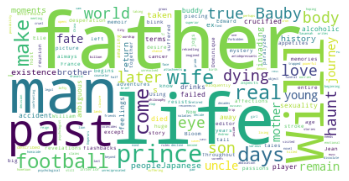

In [70]:
cloud = WordCloud(background_color='white', max_words=2000, contour_width=3, contour_color='steelblue').generate(sum_group_1)

plt.imshow(cloud)
plt.axis("off")
plt.show()

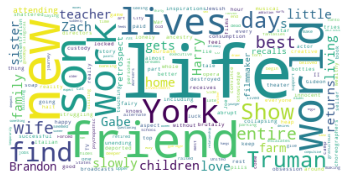

In [71]:
cloud = WordCloud(background_color='white', max_words=2000, contour_width=3, contour_color='steelblue').generate(sum_group_2)

plt.imshow(cloud)
plt.axis("off")
plt.show()

# Partie 7 : Recommandation
# Etape 1 : construction de la matrice de similarité générale 


In [72]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
import pandas as pd

df_all = pd.read_excel("/content/drive/MyDrive/UCL/Cours/M1/Q1/P2/Web Mining/Projet/Data/Output_Scrapting_TMDB.xlsx") # nos données obtenue précédemment
df_all.drop("Unnamed: 0", inplace = True, axis = 1) # pour retirer la colonne inutile crée par défaut dans le fichier xlsx

In [74]:
df_all

,Movie_id,Title,Summary,Rate,Year,Realease Date,Duration (min),Genre,Director,Actor,Budget,Revenu
0,1,Toy Story,"Led by Woody, Andy's toys live happily in his ...",8.0,1995,11/22/1995,81,"['Animation', 'Adventure', 'Family', 'Comedy']",John Lasseter,"['Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim...","$30,000,000","$373,554,033"
1,2,Jumanji,When siblings Judy and Peter discover an encha...,7.2,1995,03/28/1996,104,"['Adventure', 'Fantasy', 'Family']",Joe Johnston,"['Robin Williams', 'Kirsten Dunst', 'Bradley P...","$65,000,000","$262,821,940"
2,3,Grumpier Old Men,A family wedding reignites the ancient feud be...,6.4,1995,12/22/1995,101,"['Romance', 'Comedy']",Mark Steven Johnson,"['Walter Matthau', 'Jack Lemmon', 'Ann-Margret...","$25,000,000","$71,500,000"
3,4,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",6.3,1995,12/22/1995,127,"['Comedy', 'Drama', 'Romance']",Terry McMillan,"['Whitney Houston', 'Angela Bassett', 'Loretta...","$16,000,000","$81,452,156"
4,5,Father of the Bride Part II,Just when George Banks has recovered from his ...,6.2,1995,12/08/1995,106,"['Comedy', 'Family']",Charles Shyer,"['Steve Martin', 'Diane Keaton', 'Martin Short...",NaN,"$76,594,107"
...,...,...,...,...,...,...,...,...,...,...,...,...
9107,162672,Mohenjo Daro,"During the Indus valley civilization, an Indig...",6.4,2016,08/12/2016,155,"['Adventure', 'Drama', 'History', 'Romance']",Ashutosh Gowariker,"['Hrithik Roshan', 'Pooja Hegde', 'Kabir Bedi'...","$17,000,000","$16,000,000"
9108,163056,Shin Godzilla,"When a massive, gilled monster emerges from th...",7.1,2016,08/12/2016,2,"['Action', 'Science Fiction', 'Horror']",Hideaki Anno,"['Hiroki Hasegawa', 'Yutaka Takenouchi', 'Sato...","$15,000,000","$77,947,607"
9109,163949,The Beatles: Eight Days a Week - The Touring Y...,The Beatles stormed through Europe's music sce...,7.6,2016,09/16/2016,106,['Documentary'],Ron Howard,"['Paul McCartney', 'Ringo Starr', 'John Lennon...",NaN,"$12,283,800"
9110,164977,The Gay Desperado,Opera singer Chivo is currently playing a sing...,2.0,1936,01/01/1936,86,"['Music', 'Comedy']",Rouben Mamoulian,"['Nino Martini', 'Ida Lupino', 'Leo Carrillo',...",NaN,NaN


In [75]:
# movie n'ayant pas de résumé 
condition = df_all.Summary != "None"
df_with_sum = df_all[condition]

list_movie_id_ok = []
for id in df_with_sum.Movie_id:
  list_movie_id_ok.append(id)
print(list_movie_id_ok)
df_with_sum

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 107, 108, 110, 111, 112, 113, 114, 116, 117, 118, 119, 121, 122, 123, 124, 125, 126, 129, 130, 131, 132, 135, 137, 140, 141, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 183, 184, 185, 186, 187, 188, 189, 190, 191, 193, 194, 195, 196, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 211, 213, 214, 215, 216, 217, 218, 219, 220, 222, 223, 224, 225, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 

,Movie_id,Title,Summary,Rate,Year,Realease Date,Duration (min),Genre,Director,Actor,Budget,Revenu
0,1,Toy Story,"Led by Woody, Andy's toys live happily in his ...",8.0,1995,11/22/1995,81,"['Animation', 'Adventure', 'Family', 'Comedy']",John Lasseter,"['Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim...","$30,000,000","$373,554,033"
1,2,Jumanji,When siblings Judy and Peter discover an encha...,7.2,1995,03/28/1996,104,"['Adventure', 'Fantasy', 'Family']",Joe Johnston,"['Robin Williams', 'Kirsten Dunst', 'Bradley P...","$65,000,000","$262,821,940"
2,3,Grumpier Old Men,A family wedding reignites the ancient feud be...,6.4,1995,12/22/1995,101,"['Romance', 'Comedy']",Mark Steven Johnson,"['Walter Matthau', 'Jack Lemmon', 'Ann-Margret...","$25,000,000","$71,500,000"
3,4,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",6.3,1995,12/22/1995,127,"['Comedy', 'Drama', 'Romance']",Terry McMillan,"['Whitney Houston', 'Angela Bassett', 'Loretta...","$16,000,000","$81,452,156"
4,5,Father of the Bride Part II,Just when George Banks has recovered from his ...,6.2,1995,12/08/1995,106,"['Comedy', 'Family']",Charles Shyer,"['Steve Martin', 'Diane Keaton', 'Martin Short...",NaN,"$76,594,107"
...,...,...,...,...,...,...,...,...,...,...,...,...
9107,162672,Mohenjo Daro,"During the Indus valley civilization, an Indig...",6.4,2016,08/12/2016,155,"['Adventure', 'Drama', 'History', 'Romance']",Ashutosh Gowariker,"['Hrithik Roshan', 'Pooja Hegde', 'Kabir Bedi'...","$17,000,000","$16,000,000"
9108,163056,Shin Godzilla,"When a massive, gilled monster emerges from th...",7.1,2016,08/12/2016,2,"['Action', 'Science Fiction', 'Horror']",Hideaki Anno,"['Hiroki Hasegawa', 'Yutaka Takenouchi', 'Sato...","$15,000,000","$77,947,607"
9109,163949,The Beatles: Eight Days a Week - The Touring Y...,The Beatles stormed through Europe's music sce...,7.6,2016,09/16/2016,106,['Documentary'],Ron Howard,"['Paul McCartney', 'Ringo Starr', 'John Lennon...",NaN,"$12,283,800"
9110,164977,The Gay Desperado,Opera singer Chivo is currently playing a sing...,2.0,1936,01/01/1936,86,"['Music', 'Comedy']",Rouben Mamoulian,"['Nino Martini', 'Ida Lupino', 'Leo Carrillo',...",NaN,NaN


In [76]:
# movie ayant un résumé
condition = df_all.Summary != "None"
df = df_all[condition]    
df

,Movie_id,Title,Summary,Rate,Year,Realease Date,Duration (min),Genre,Director,Actor,Budget,Revenu
0,1,Toy Story,"Led by Woody, Andy's toys live happily in his ...",8.0,1995,11/22/1995,81,"['Animation', 'Adventure', 'Family', 'Comedy']",John Lasseter,"['Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim...","$30,000,000","$373,554,033"
1,2,Jumanji,When siblings Judy and Peter discover an encha...,7.2,1995,03/28/1996,104,"['Adventure', 'Fantasy', 'Family']",Joe Johnston,"['Robin Williams', 'Kirsten Dunst', 'Bradley P...","$65,000,000","$262,821,940"
2,3,Grumpier Old Men,A family wedding reignites the ancient feud be...,6.4,1995,12/22/1995,101,"['Romance', 'Comedy']",Mark Steven Johnson,"['Walter Matthau', 'Jack Lemmon', 'Ann-Margret...","$25,000,000","$71,500,000"
3,4,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",6.3,1995,12/22/1995,127,"['Comedy', 'Drama', 'Romance']",Terry McMillan,"['Whitney Houston', 'Angela Bassett', 'Loretta...","$16,000,000","$81,452,156"
4,5,Father of the Bride Part II,Just when George Banks has recovered from his ...,6.2,1995,12/08/1995,106,"['Comedy', 'Family']",Charles Shyer,"['Steve Martin', 'Diane Keaton', 'Martin Short...",NaN,"$76,594,107"
...,...,...,...,...,...,...,...,...,...,...,...,...
9107,162672,Mohenjo Daro,"During the Indus valley civilization, an Indig...",6.4,2016,08/12/2016,155,"['Adventure', 'Drama', 'History', 'Romance']",Ashutosh Gowariker,"['Hrithik Roshan', 'Pooja Hegde', 'Kabir Bedi'...","$17,000,000","$16,000,000"
9108,163056,Shin Godzilla,"When a massive, gilled monster emerges from th...",7.1,2016,08/12/2016,2,"['Action', 'Science Fiction', 'Horror']",Hideaki Anno,"['Hiroki Hasegawa', 'Yutaka Takenouchi', 'Sato...","$15,000,000","$77,947,607"
9109,163949,The Beatles: Eight Days a Week - The Touring Y...,The Beatles stormed through Europe's music sce...,7.6,2016,09/16/2016,106,['Documentary'],Ron Howard,"['Paul McCartney', 'Ringo Starr', 'John Lennon...",NaN,"$12,283,800"
9110,164977,The Gay Desperado,Opera singer Chivo is currently playing a sing...,2.0,1936,01/01/1936,86,"['Music', 'Comedy']",Rouben Mamoulian,"['Nino Martini', 'Ida Lupino', 'Leo Carrillo',...",NaN,NaN


In [77]:
import numpy as np
import pandas as pd
from nltk.stem.porter import PorterStemmer  # pour steam
from sklearn.feature_extraction.text import CountVectorizer #count vectorizor
from sklearn.metrics.pairwise import cosine_similarity  # pour le calcul de similarité entre vecteur film

In [78]:
ps = PorterStemmer() # pour faire le stemming 

# fonction pour stem chaque résumé
def stem(text):
    y=[]
    
    for i in text.split():
        y.append(ps.stem(i))
    return " ".join(y)
#fonction pour remplacer chaque résumé par sa version stem
for index,row in df.iterrows():
    #print(index)
    df.loc[index, 'Summary'] = stem(row['Summary'])

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [79]:
df

,Movie_id,Title,Summary,Rate,Year,Realease Date,Duration (min),Genre,Director,Actor,Budget,Revenu
0,1,Toy Story,"led by woody, andy' toy live happili in hi roo...",8.0,1995,11/22/1995,81,"['Animation', 'Adventure', 'Family', 'Comedy']",John Lasseter,"['Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim...","$30,000,000","$373,554,033"
1,2,Jumanji,when sibl judi and peter discov an enchant boa...,7.2,1995,03/28/1996,104,"['Adventure', 'Fantasy', 'Family']",Joe Johnston,"['Robin Williams', 'Kirsten Dunst', 'Bradley P...","$65,000,000","$262,821,940"
2,3,Grumpier Old Men,a famili wed reignit the ancient feud between ...,6.4,1995,12/22/1995,101,"['Romance', 'Comedy']",Mark Steven Johnson,"['Walter Matthau', 'Jack Lemmon', 'Ann-Margret...","$25,000,000","$71,500,000"
3,4,Waiting to Exhale,"cheat on, mistreat and step on, the women are ...",6.3,1995,12/22/1995,127,"['Comedy', 'Drama', 'Romance']",Terry McMillan,"['Whitney Houston', 'Angela Bassett', 'Loretta...","$16,000,000","$81,452,156"
4,5,Father of the Bride Part II,just when georg bank ha recov from hi daughter...,6.2,1995,12/08/1995,106,"['Comedy', 'Family']",Charles Shyer,"['Steve Martin', 'Diane Keaton', 'Martin Short...",NaN,"$76,594,107"
...,...,...,...,...,...,...,...,...,...,...,...,...
9107,162672,Mohenjo Daro,"dure the indu valley civilization, an indigo f...",6.4,2016,08/12/2016,155,"['Adventure', 'Drama', 'History', 'Romance']",Ashutosh Gowariker,"['Hrithik Roshan', 'Pooja Hegde', 'Kabir Bedi'...","$17,000,000","$16,000,000"
9108,163056,Shin Godzilla,"when a massive, gill monster emerg from the de...",7.1,2016,08/12/2016,2,"['Action', 'Science Fiction', 'Horror']",Hideaki Anno,"['Hiroki Hasegawa', 'Yutaka Takenouchi', 'Sato...","$15,000,000","$77,947,607"
9109,163949,The Beatles: Eight Days a Week - The Touring Y...,the beatl storm through europe' music scene in...,7.6,2016,09/16/2016,106,['Documentary'],Ron Howard,"['Paul McCartney', 'Ringo Starr', 'John Lennon...",NaN,"$12,283,800"
9110,164977,The Gay Desperado,opera singer chivo is current play a sing cowb...,2.0,1936,01/01/1936,86,"['Music', 'Comedy']",Rouben Mamoulian,"['Nino Martini', 'Ida Lupino', 'Leo Carrillo',...",NaN,NaN


In [80]:
count_v = CountVectorizer(max_features=5000,stop_words='english')
vectors = count_v.fit_transform(df.Summary).toarray() # création de plusieurs vecteurs. nbr de vecteurs = nbr de films 
print(vectors)
print(len(vectors))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
9050


In [81]:
count_v.get_feature_names() # contient l'ensemble des mots bag of words

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['000',
 '10',
 '100',
 '11',
 '12',
 '13',
 '14',
 '15',
 '150',
 '16',
 '16th',
 '17',
 '17th',
 '18',
 '18th',
 '19',
 '1900',
 '1920',
 '1920s',
 '1930',
 '1930s',
 '1939',
 '1940',
 '1941',
 '1942',
 '1943',
 '1944',
 '1945',
 '1950',
 '1950s',
 '1955',
 '1957',
 '1960',
 '1960s',
 '1962',
 '1963',
 '1964',
 '1965',
 '1970',
 '1970s',
 '1971',
 '1972',
 '1973',
 '1974',
 '1976',
 '1977',
 '1978',
 '1979',
 '1980',
 '1980s',
 '1981',
 '1983',
 '1984',
 '1986',
 '1990',
 '1992',
 '1994',
 '1995',
 '1996',
 '1999',
 '19th',
 '20',
 '200',
 '2000',
 '2001',
 '2007',
 '2008',
 '2009',
 '2011',
 '20th',
 '21st',
 '24',
 '25',
 '26',
 '28',
 '30',
 '300',
 '35',
 '40',
 '400',
 '50',
 '500',
 '60',
 '600',
 '70',
 '80',
 '90',
 'aaron',
 'abandon',
 'abbi',
 'abduct',
 'abil',
 'abilities',
 'abl',
 'aboard',
 'abov',
 'abroad',
 'absenc',
 'absence',
 'absorb',
 'abus',
 'abuse',
 'academ',
 'academi',
 'academy',
 'accept',
 'access',
 'accid',
 'accident',
 'acclaim',
 'accompani',
 '

In [82]:
matrice_similarity = cosine_similarity(vectors) # matrice de similatité 
matrice_similarity[0]   # il aura une similarité de 1 pour lui même

array([1.        , 0.0439587 , 0.        , ..., 0.03976214, 0.03686049,
       0.        ])

In [83]:
matrice_similarity.shape # dimension de la matrice

(9050, 9050)

In [84]:
# création d'un dico_movie_id_title
dico_movie_id_title = {}
list_id, list_title = [], []
for id in df.Movie_id:
  list_id.append(id)
for title in df.Title:
  list_title.append(title)
for i in range(len(list_id)):
  id = list_id[i]
  title = list_title[i]
  dico_movie_id_title[str(id)] = title
print(dico_movie_id_title)

{'1': 'Toy Story', '2': 'Jumanji', '3': 'Grumpier Old Men', '4': 'Waiting to Exhale', '5': 'Father of the Bride Part II', '6': 'Heat', '7': 'Sabrina', '8': 'Tom and Huck', '9': 'Sudden Death', '10': 'GoldenEye', '11': 'The American President', '12': 'Dracula: Dead and Loving It', '13': 'Balto', '14': 'Nixon', '15': 'Cutthroat Island', '16': 'Casino', '17': 'Sense and Sensibility', '18': 'Four Rooms', '19': 'Ace Ventura: When Nature Calls', '20': 'Money Train', '21': 'Get Shorty', '22': 'Copycat', '23': 'Assassins', '24': 'Powder', '25': 'Leaving Las Vegas', '26': 'Othello', '27': 'Now and Then', '28': 'Persuasion', '29': 'The City of Lost Children', '30': 'Shanghai Triad', '31': 'Dangerous Minds', '32': 'Twelve Monkeys', '34': 'Babe', '35': 'Carrington', '36': 'Dead Man Walking', '37': 'Across the Sea of Time', '38': 'It Takes Two', '39': 'Clueless', '40': 'Cry, the Beloved Country', '41': 'Richard III', '42': 'Dead Presidents', '43': 'Restoration', '44': 'Mortal Kombat', '45': 'To Die

In [85]:
# fct qui va renvoyer les 3 premiers films recommendable en fct du titre entré en paramètre 
def recommendation(movie_title):
    #movie_index = new_df[new_df['title'] == movie].index[0]
    movie_list = df[df['Title'].str.contains(movie_title)]

    movie_idx= movie_list.index[0] # index du film 
    distances = matrice_similarity[movie_idx]
    list_movie = sorted(list(enumerate(distances)),reverse=True, key=lambda x:x[1])[1:4]   # chaque élément contient un tuple avec l'index et le score de similarité
    # lambda pour aller classer les similarité et non les movie_id
    
    # on va renvoyer le résultat 
    list_result = []
    for i in list_movie:
      list_result.append(df.iloc[i[0]].Title)
    #print(list_movie)
    return list_result
recommendation("Daria in 'Is It Fall Yet?")

['Stripes', 'At First Sight', 'The Closet']

In [86]:
df

,Movie_id,Title,Summary,Rate,Year,Realease Date,Duration (min),Genre,Director,Actor,Budget,Revenu
0,1,Toy Story,"led by woody, andy' toy live happili in hi roo...",8.0,1995,11/22/1995,81,"['Animation', 'Adventure', 'Family', 'Comedy']",John Lasseter,"['Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim...","$30,000,000","$373,554,033"
1,2,Jumanji,when sibl judi and peter discov an enchant boa...,7.2,1995,03/28/1996,104,"['Adventure', 'Fantasy', 'Family']",Joe Johnston,"['Robin Williams', 'Kirsten Dunst', 'Bradley P...","$65,000,000","$262,821,940"
2,3,Grumpier Old Men,a famili wed reignit the ancient feud between ...,6.4,1995,12/22/1995,101,"['Romance', 'Comedy']",Mark Steven Johnson,"['Walter Matthau', 'Jack Lemmon', 'Ann-Margret...","$25,000,000","$71,500,000"
3,4,Waiting to Exhale,"cheat on, mistreat and step on, the women are ...",6.3,1995,12/22/1995,127,"['Comedy', 'Drama', 'Romance']",Terry McMillan,"['Whitney Houston', 'Angela Bassett', 'Loretta...","$16,000,000","$81,452,156"
4,5,Father of the Bride Part II,just when georg bank ha recov from hi daughter...,6.2,1995,12/08/1995,106,"['Comedy', 'Family']",Charles Shyer,"['Steve Martin', 'Diane Keaton', 'Martin Short...",NaN,"$76,594,107"
...,...,...,...,...,...,...,...,...,...,...,...,...
9107,162672,Mohenjo Daro,"dure the indu valley civilization, an indigo f...",6.4,2016,08/12/2016,155,"['Adventure', 'Drama', 'History', 'Romance']",Ashutosh Gowariker,"['Hrithik Roshan', 'Pooja Hegde', 'Kabir Bedi'...","$17,000,000","$16,000,000"
9108,163056,Shin Godzilla,"when a massive, gill monster emerg from the de...",7.1,2016,08/12/2016,2,"['Action', 'Science Fiction', 'Horror']",Hideaki Anno,"['Hiroki Hasegawa', 'Yutaka Takenouchi', 'Sato...","$15,000,000","$77,947,607"
9109,163949,The Beatles: Eight Days a Week - The Touring Y...,the beatl storm through europe' music scene in...,7.6,2016,09/16/2016,106,['Documentary'],Ron Howard,"['Paul McCartney', 'Ringo Starr', 'John Lennon...",NaN,"$12,283,800"
9110,164977,The Gay Desperado,opera singer chivo is current play a sing cowb...,2.0,1936,01/01/1936,86,"['Music', 'Comedy']",Rouben Mamoulian,"['Nino Martini', 'Ida Lupino', 'Leo Carrillo',...",NaN,NaN


# Partie 7, étape 2 : recommandation utilisateur 

In [87]:
df_rating = pd.read_csv("/content/drive/MyDrive/UCL/Cours/M1/Q1/P2/Web Mining/Projet/Data/ratings.csv")
df_rating

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


In [88]:
total_movie_rated = len(df_rating.movieId.unique())
total_user = len(df_rating.userId.unique())
print(f"total movie rated : {total_movie_rated}")
print(f"total user : {total_user}")

total movie rated : 9066
total user : 671


In [89]:
print(len(list_movie_id_ok)) # liste récupérer dans la section d'avant 

9050


In [100]:
# on ne va garder que les notes supérieurs à 3.5 sur 5 
condition = df_rating.rating >= 3.5
df_rating = df_rating[condition]
df_rating

,userId,movieId,rating,timestamp
4,1,1172,4.0,1260759205
8,1,1339,3.5,1260759125
12,1,1953,4.0,1260759191
13,1,2105,4.0,1260759139
20,2,10,4.0,835355493
...,...,...,...,...
99996,671,5991,4.5,1064245387
99997,671,5995,4.0,1066793014
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363


In [91]:
total_movie_rated = len(df_rating.movieId.unique())
total_user = len(df_rating.userId.unique())
print(f"total movie rated : {total_movie_rated}")
print(f"total user : {total_user}")

total movie rated : 6993
total user : 671


In [92]:
# on va garder les movie_id qui on un résumé
# donc qui ne se trouve dans list_movie_id_ok 
condition = df_rating.movieId.isin(list_movie_id_ok)
df_rating_2 = df_rating[condition]
df_rating_2

,userId,movieId,rating,timestamp
4,1,1172,4.0,1260759205
8,1,1339,3.5,1260759125
12,1,1953,4.0,1260759191
13,1,2105,4.0,1260759139
20,2,10,4.0,835355493
...,...,...,...,...
99996,671,5991,4.5,1064245387
99997,671,5995,4.0,1066793014
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363


In [93]:
print(dico_movie_id_title) # récupéré dans la section précédente
print(len(dico_movie_id_title))

{'1': 'Toy Story', '2': 'Jumanji', '3': 'Grumpier Old Men', '4': 'Waiting to Exhale', '5': 'Father of the Bride Part II', '6': 'Heat', '7': 'Sabrina', '8': 'Tom and Huck', '9': 'Sudden Death', '10': 'GoldenEye', '11': 'The American President', '12': 'Dracula: Dead and Loving It', '13': 'Balto', '14': 'Nixon', '15': 'Cutthroat Island', '16': 'Casino', '17': 'Sense and Sensibility', '18': 'Four Rooms', '19': 'Ace Ventura: When Nature Calls', '20': 'Money Train', '21': 'Get Shorty', '22': 'Copycat', '23': 'Assassins', '24': 'Powder', '25': 'Leaving Las Vegas', '26': 'Othello', '27': 'Now and Then', '28': 'Persuasion', '29': 'The City of Lost Children', '30': 'Shanghai Triad', '31': 'Dangerous Minds', '32': 'Twelve Monkeys', '34': 'Babe', '35': 'Carrington', '36': 'Dead Man Walking', '37': 'Across the Sea of Time', '38': 'It Takes Two', '39': 'Clueless', '40': 'Cry, the Beloved Country', '41': 'Richard III', '42': 'Dead Presidents', '43': 'Restoration', '44': 'Mortal Kombat', '45': 'To Die

In [94]:
dico_movie_id_title['1']

'Toy Story'

In [98]:
# fct pour aller chercher le titre du premier film aimé par un utilisateur
# en parametre user_id
def get_movie_title(id_user):
  condition = df_rating_2.userId == id_user
  df_new = df_rating_2[condition]
  data = list(df_new.movieId)
  movie_id = data[0]
  title = dico_movie_id_title[str(movie_id)] # le titre du premier film de la liste
  return title # le premier film de la liste
# fct où on va renvoyer une data frame contenant l'user, le film aimé, les 3 film recommandés
def get_recommendation():
  list_user = list(df_rating_2.userId.unique())
  list_movie_recommendation_1, list_movie_recommendation_2, list_movie_recommendation_3 = [], [], []
  list_movie_name = []
  for user_id in range(1, (len(list_user) + 1) ):
    title = get_movie_title(user_id)
    list_3_movie = recommendation(title)
    list_movie_recommendation_1.append(list_3_movie[0])
    list_movie_recommendation_2.append(list_3_movie[1])
    list_movie_recommendation_3.append(list_3_movie[2])
    list_movie_name.append(title)
  dico_result = {
      "User_id": list_user,
      "Movie_liked": list_movie_name,
      "Recommended_movie_1": list_movie_recommendation_1,
      "Recommended_movie_2": list_movie_recommendation_2,
      "Recommended_movie_3": list_movie_recommendation_3
  }
  df_result = pd.DataFrame(dico_result)
  return df_result
df_recom = get_recommendation()
df_recom

,User_id,Movie_liked,Recommended_movie_1,Recommended_movie_2,Recommended_movie_3
0,1,Cinema Paradiso,Stardust Memories,Cyrano de Bergerac,All That Jazz
1,2,GoldenEye,Never Say Never Again,From Russia with Love,Casino Royale
2,3,Braveheart,Certified Copy,C.R.A.Z.Y.,Dummy
3,4,GoldenEye,Never Say Never Again,From Russia with Love,Casino Royale
4,5,Grumpier Old Men,Go Fish,Gone Fishin',Attack of the Giant Leeches
...,...,...,...,...,...
666,667,Heat,Blue Steel,Enemy at the Gates,The Town
667,668,Pulp Fiction,Ghost Dog: The Way of the Samurai,One Good Cop,Phantasm IV: Oblivion
668,669,Clerks,Edtv,The Good Girl,Brief Encounter
669,670,Toy Story,Toy Story 2,Toy Story 3,Harry Potter and the Philosopher's Stone


In [99]:
df_recom.to_excel("Recommandation.xlsx")